In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/msc_final_dataset/final_with_polarity_sbert.csv")
print(df.shape)
print(df.columns.tolist())

(5966, 18)
['Text', 'Emotion_Label', 'Emoji', 'Image_Reference', 'Subcommunity_Tag', 'Modality_Type', 'Social_Media_Type', 'Source', 'Image_Local_Path', 'local_path', 'status', 'OCR_Text', 'Text_Combined', 'Emoji_Extracted', 'Polarity_Label', 'Combined_Text', 'Emoji_Sentiment', 'Cluster_SBERT_k8']


In [ ]:
!pip -q install -U sentence-transformers umap-learn scikit-learn openpyxl

# Import libraries required
import os, json, numpy as np, pandas as pd
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
import umap
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = "/content/drive/MyDrive/msc_final_dataset/final_with_polarity_sbert.csv"
OUT_DIR   = "/content/drive/MyDrive/msc_final_dataset/chapter4_results"
os.makedirs(OUT_DIR, exist_ok=True)

print("Writing outputs to:", OUT_DIR)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.6/486.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 87.5 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Writing outputs to: /content/drive/MyDrive/msc_final_dataset/chapter4_results


In [ ]:
df = pd.read_csv(DATA_PATH)
print(df.shape)
print(df.columns.tolist()[:20])

text_col = None
for candidate in ["Text_Combined","Combined_Text","Text"]:
    if candidate in df.columns:
        text_col = candidate
        break
assert text_col is not None, "No text field found."
print("Using text column:", text_col)

# basic clean
texts = df[text_col].fillna("").astype(str).str.strip()
mask_nonempty = texts.str.len() > 0
texts = texts[mask_nonempty]
df_work = df.loc[mask_nonempty].copy()
print("Non-empty texts:", len(texts))

(5966, 18)
['Text', 'Emotion_Label', 'Emoji', 'Image_Reference', 'Subcommunity_Tag', 'Modality_Type', 'Social_Media_Type', 'Source', 'Image_Local_Path', 'local_path', 'status', 'OCR_Text', 'Text_Combined', 'Emoji_Extracted', 'Polarity_Label', 'Combined_Text', 'Emoji_Sentiment', 'Cluster_SBERT_k8']
Using text column: Text_Combined
Non-empty texts: 5966


In [ ]:
EMBED_CACHE = os.path.join(OUT_DIR, "sbert_embeddings.npy")

model_name = "sentence-transformers/all-mpnet-base-v2"  # 768-dim
model = SentenceTransformer(model_name)

if os.path.exists(EMBED_CACHE):
    X = np.load(EMBED_CACHE)
    print("Loaded cached embeddings:", X.shape)
else:
    batch = texts.tolist()
    X = model.encode(batch, batch_size=64, show_progress_bar=True, normalize_embeddings=True)
    X = np.asarray(X, dtype=np.float32)
    np.save(EMBED_CACHE, X)
    print("Saved embeddings:", X.shape)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/94 [00:00<?, ?it/s]

Saved embeddings: (5966, 768)


In [ ]:
# PCA to 50 dims
pca_50 = PCA(n_components=50, random_state=42)
X_pca = pca_50.fit_transform(X)

# UMAP to 50 dims (pre-clustering space)
umap_50 = umap.UMAP(
    n_neighbors=15, min_dist=0.1, n_components=50,
    metric='cosine', random_state=42
)
X_umap50 = umap_50.fit_transform(X_pca)

# UMAP to 2D (for visualization)
umap_2d = umap.UMAP(
    n_neighbors=15, min_dist=0.1, n_components=2,
    metric='cosine', random_state=42
)
X_2d = umap_2d.fit_transform(X_pca)
np.save(os.path.join(OUT_DIR, "umap2d.npy"), X_2d)
print("Shapes -> X:", X.shape, " PCA50:", X_pca.shape, " UMAP50:", X_umap50.shape, " UMAP2D:", X_2d.shape)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Shapes -> X: (5966, 768)  PCA50: (5966, 50)  UMAP50: (5966, 50)  UMAP2D: (5966, 2)


In [ ]:
ks = list(range(2, 21))
results = []

for k in ks:
    km = KMeans(n_clusters=k, init='k-means++', n_init=20, max_iter=500, random_state=42)
    labels = km.fit_predict(X_umap50)
    sil = silhouette_score(X_umap50, labels, metric='euclidean')
    ch  = calinski_harabasz_score(X_umap50, labels)
    db  = davies_bouldin_score(X_umap50, labels)
    results.append({"k":k, "silhouette":sil, "calinski_harabasz":ch, "davies_bouldin":db})

sweep = pd.DataFrame(results)
sweep.to_csv(os.path.join(OUT_DIR, "k_sweep_metrics.csv"), index=False)
sweep

,k,silhouette,calinski_harabasz,davies_bouldin
0,2,0.316746,2911.649170,1.270031
1,3,0.384979,3896.173828,0.939157
2,4,0.324094,3437.513428,1.066408
3,5,0.310027,3296.861816,1.193449
4,6,0.345585,3341.972168,1.021668
5,7,0.342406,3315.221680,1.048644
6,8,0.343657,3241.420654,0.990908
7,9,0.333483,3178.150146,1.023686
8,10,0.337729,3176.273682,1.083774
9,11,0.344449,3140.336182,1.073408


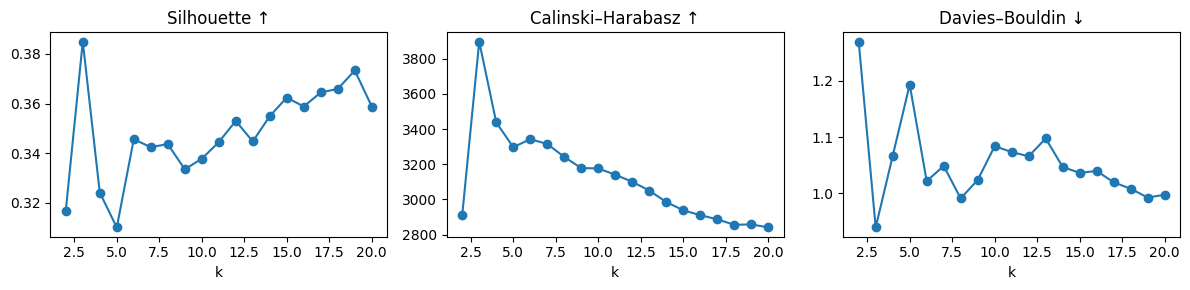

In [ ]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1); plt.plot(sweep["k"], sweep["silhouette"], marker='o'); plt.title("Silhouette ↑"); plt.xlabel("k")
plt.subplot(1,3,2); plt.plot(sweep["k"], sweep["calinski_harabasz"], marker='o'); plt.title("Calinski–Harabasz ↑"); plt.xlabel("k")
plt.subplot(1,3,3); plt.plot(sweep["k"], sweep["davies_bouldin"], marker='o'); plt.title("Davies–Bouldin ↓"); plt.xlabel("k")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "k_sweep_plots.png"), dpi=200)
plt.show()

In [ ]:
BEST_K = 8

kmeans = KMeans(n_clusters=BEST_K, init='k-means++', n_init=20, max_iter=500, random_state=42)
final_labels = kmeans.fit_predict(X_umap50)

df_work["Cluster_SBERT"] = final_labels
df.loc[df_work.index, "Cluster_SBERT"] = final_labels  # merge back to original rows (NaN for empty-text rows)
df["Cluster_SBERT"] = df["Cluster_SBERT"].astype("Int64")

df["Cluster_SBERT"].value_counts(dropna=False).sort_index()

,count
Cluster_SBERT,
0,647
1,1223
2,1552
3,473
4,575
5,1016
6,259
7,221


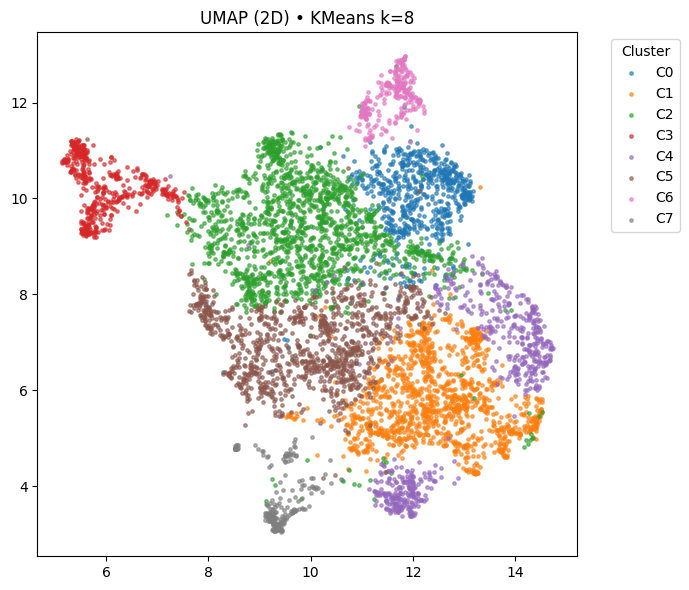

In [ ]:
plt.figure(figsize=(7,6))
palette = sns.color_palette("tab10", n_colors=BEST_K)
for c in range(BEST_K):
    idx = (df_work["Cluster_SBERT"] == c).values
    plt.scatter(X_2d[idx,0], X_2d[idx,1], s=6, alpha=0.6, label=f"C{c}", color=palette[c])
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.title(f"UMAP (2D) • KMeans k={BEST_K}")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, f"umap2d_k{BEST_K}.png"), dpi=250)
plt.show()

In [ ]:
# TF-IDF top terms per cluster
vectorizer = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1,2),
    min_df=2,
    stop_words='english'
)
tfidf = vectorizer.fit_transform(df_work[text_col].fillna("").astype(str))
terms = np.array(vectorizer.get_feature_names_out())

rows = []
for c in range(BEST_K):
    idx = (df_work["Cluster_SBERT"] == c).values
    if idx.sum() == 0:
        continue
    tfidf_mean = tfidf[idx].mean(axis=0).A1
    top_idx = tfidf_mean.argsort()[::-1][:12]
    top_terms = ", ".join(terms[top_idx])

    # sizes + mixes
    size = int(idx.sum())
    plat_ct = df_work.loc[idx, "Social_Media_Type"].value_counts(dropna=False).to_dict() if "Social_Media_Type" in df_work.columns else {}
    mod_ct  = df_work.loc[idx, "Modality_Type"].value_counts(dropna=False).to_dict() if "Modality_Type" in df_work.columns else {}

    rows.append({
        "Cluster": c,
        "Size": size,
        "TopTerms": top_terms,
        "PlatformMix": json.dumps(plat_ct, ensure_ascii=False),
        "ModalityMix": json.dumps(mod_ct, ensure_ascii=False),
    })

cluster_summary = pd.DataFrame(rows).sort_values("Size", ascending=False)
cluster_summary.to_csv(os.path.join(OUT_DIR, f"cluster_summary_k{BEST_K}.csv"), index=False)
cluster_summary

,Cluster,Size,TopTerms,PlatformMix,ModalityMix
2,2,1552,"oc, love, just, like, lol, know, thanks, http,...","{""Twitter"": 1192, ""Reddit"": 360}","{""Text-only"": 1212, ""Text+Image"": 340}"
1,1,1223,"work, day, today, home, going, good, sleep, mo...","{""Twitter"": 1189, ""Reddit"": 34}","{""Text-only"": 1196, ""Text+Image"": 27}"
5,5,1016,"miss, love, good, going, watching, wish, just,...","{""Twitter"": 984, ""Reddit"": 32}","{""Text-only"": 986, ""Text+Image"": 30}"
0,0,647,"http, new, com, work, just, thanks, phone, got...","{""Twitter"": 609, ""Reddit"": 38}","{""Text-only"": 609, ""Text+Image"": 38}"
4,4,575,"headache, sick, just, feel, hot, hurts, eating...","{""Twitter"": 545, ""Reddit"": 30}","{""Text-only"": 552, ""Text+Image"": 23}"
3,3,473,"like, just, don, feel, know, ve, want, time, r...","{""Reddit"": 450, ""Twitter"": 23}","{""Text-only"": 461, ""Text+Image"": 12}"
6,6,259,"twitter, follow, tweet, followers, tweets, fol...","{""Twitter"": 254, ""Reddit"": 5}","{""Text-only"": 254, ""Text+Image"": 5}"
7,7,221,"happy, day, mother, mother day, mothers, happy...","{""Twitter"": 204, ""Reddit"": 17}","{""Text-only"": 205, ""Text+Image"": 16}"


In [ ]:
# Agglomerative (fixed k)
agg = AgglomerativeClustering(n_clusters=BEST_K, linkage="average", metric="cosine")
labels_agg = agg.fit_predict(X_umap50)

# Compute silhouette to compare
sil_km  = silhouette_score(X_umap50, final_labels, metric='euclidean')
sil_agg = silhouette_score(X_umap50, labels_agg,   metric='euclidean')
print({"silhouette_kmeans": sil_km, "silhouette_agglomerative": sil_agg})

{'silhouette_kmeans': 0.3436570167541504, 'silhouette_agglomerative': 0.30553510785102844}


In [ ]:
OUT_CSV = os.path.join(OUT_DIR, f"final_with_clusters_k{BEST_K}.csv")
df.to_csv(OUT_CSV, index=False)
print("Saved:", OUT_CSV)

Saved: /content/drive/MyDrive/msc_final_dataset/chapter4_results/final_with_clusters_k8.csv


More diagnostics for reporting example posts per cluster:

In [ ]:
import pandas as pd, json
from ast import literal_eval

OUT_DIR = "/content/drive/MyDrive/msc_final_dataset/chapter4_results"
df = pd.read_csv(f"{OUT_DIR}/final_with_clusters_k8.csv")

# choose short exemplars that match top terms (simple heuristic: shortest texts)
examples = []
for c in sorted(df["Cluster_SBERT"].dropna().unique().astype(int)):
    sub = df[df["Cluster_SBERT"]==c].copy()
    sub["len"] = sub["Text_Combined"].astype(str).str.len()
    ex = sub.sort_values("len").head(5)[["Cluster_SBERT","Social_Media_Type","Modality_Type","Subcommunity_Tag","Text_Combined"]]
    examples.append(ex)
exemplars = pd.concat(examples, ignore_index=True)
exemplars.to_csv(f"{OUT_DIR}/cluster_exemplars_k8.csv", index=False)
print("Saved exemplars ->", f"{OUT_DIR}/cluster_exemplars_k8.csv")

Saved exemplars -> /content/drive/MyDrive/msc_final_dataset/chapter4_results/cluster_exemplars_k8.csv


Bar chart Visuals = cluster sizes, platform mix, modality mix

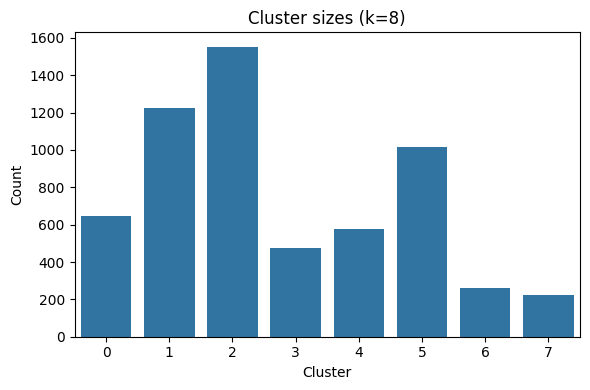

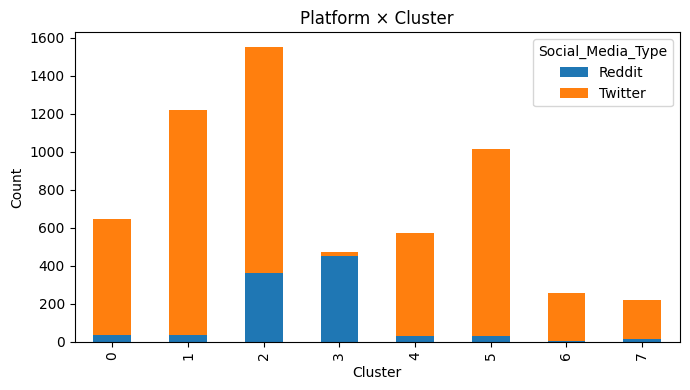

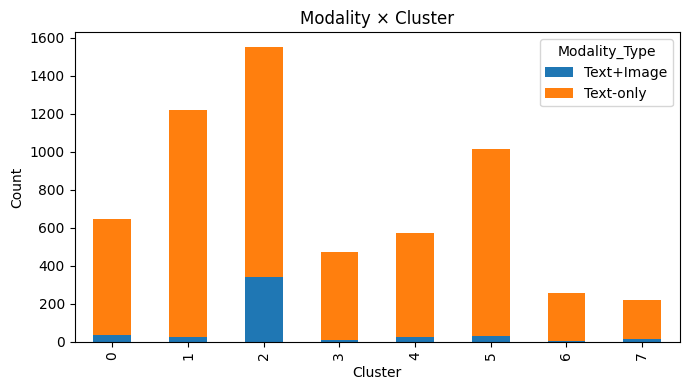

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cl = df["Cluster_SBERT"].astype("Int64")

# 1. Cluster sizes
sizes = cl.value_counts().sort_index()
plt.figure(figsize=(6,4))
sns.barplot(x=sizes.index, y=sizes.values)
plt.xlabel("Cluster"); plt.ylabel("Count"); plt.title("Cluster sizes (k=8)")
plt.tight_layout(); plt.savefig(f"{OUT_DIR}/cluster_sizes_k8.png", dpi=250)

# 2. Platform × Cluster (stacked)
plat_tab = pd.crosstab(cl, df["Social_Media_Type"])
plat_tab.plot(kind="bar", stacked=True, figsize=(7,4))
plt.xlabel("Cluster"); plt.ylabel("Count"); plt.title("Platform × Cluster")
plt.tight_layout(); plt.savefig(f"{OUT_DIR}/platform_by_cluster_k8.png", dpi=250)

# 3. Modality × Cluster (stacked)
mod_tab = pd.crosstab(cl, df["Modality_Type"])
mod_tab.plot(kind="bar", stacked=True, figsize=(7,4))
plt.xlabel("Cluster"); plt.ylabel("Count"); plt.title("Modality × Cluster")
plt.tight_layout(); plt.savefig(f"{OUT_DIR}/modality_by_cluster_k8.png", dpi=250)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import numpy as np

# Reuse = X_umap50
X_umap50 = np.load(f"{OUT_DIR}/umap2d.npy")

km_a = KMeans(n_clusters=8, n_init=20, random_state=42).fit(X_umap50)
km_b = KMeans(n_clusters=8, n_init=20, random_state=123).fit(X_umap50)
print("ARI between runs:", adjusted_rand_score(km_a.labels_, km_b.labels_))

ARI between runs: 1.0


Cluster Characterisation (4.2.3)

In [ ]:
import os, numpy as np, pandas as pd

DATA = "/content/drive/MyDrive/msc_final_dataset/final_with_polarity_sbert.csv"
EMB  = "/content/drive/MyDrive/msc_final_dataset/chapter4_outputs/sbert_all_mpnet_base_v2_norm.npy"

df = pd.read_csv(DATA)

# normalize the column name for cluster labels
label_cols = [c for c in df.columns if c.lower() in {"cluster_sbert","cluster_sbert_k8","cluster","cluster_kmeans"}]
print("Found label columns:", label_cols)

if "Cluster_SBERT" not in df.columns:
    if "Cluster_SBERT_k8" in df.columns:
        df = df.rename(columns={"Cluster_SBERT_k8":"Cluster_SBERT"})
    elif label_cols:
        df = df.rename(columns={label_cols[0]:"Cluster_SBERT"})
    else:
        raise AssertionError("No cluster label column found. Run KMeans to create one (see Option B).")

# save a canonical copy so all later steps see the same field name
df.to_csv(DATA, index=False)
print("Labels available as 'Cluster_SBERT'. Shape:", df.shape)

Found label columns: ['Cluster_SBERT_k8']
Labels available as 'Cluster_SBERT'. Shape: (5966, 18)


In [ ]:
# 4.2.3 — Cluster profiling, descriptors & exemplars
import os, json, numpy as np, pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances

RESULTS_DIR = "/content/drive/MyDrive/msc_final_dataset/chapter4_results"
OUT_DIR     = RESULTS_DIR  # keep outputs alongside other chapter4 results
os.makedirs(OUT_DIR, exist_ok=True)

# Load the clustered dataset (final_with_clusters_k8.csv)
DATA = os.path.join(RESULTS_DIR, "final_with_clusters_k8.csv")
df = pd.read_csv(DATA)

# pick the cluster column -Cluster_SBERT_k8
if "Cluster_SBERT" in df.columns:
    df["Cluster_SBERT"] = df["Cluster_SBERT"].astype("Int64")
elif "Cluster_SBERT_k8" in df.columns:
    df["Cluster_SBERT"] = df["Cluster_SBERT_k8"].astype("Int64")
else:
    raise ValueError("No cluster column found. Expecting Cluster_SBERT or Cluster_SBERT_k8.")

#Load embeddings from where they are saved
EMB_CANDIDATES = [
    os.path.join(RESULTS_DIR, "sbert_embeddings.npy"),
    "/content/drive/MyDrive/msc_final_dataset/chapter4_outputs/sbert_all_mpnet_base_v2_norm.npy",
]
EMB = next((p for p in EMB_CANDIDATES if os.path.exists(p)), None)
if EMB is None:
    raise FileNotFoundError("SBERT .npy embeddings not found. Expected one of:\n" + "\n".join(EMB_CANDIDATES))
X = np.load(EMB)

# Ensure Text_Combined exists and is clean
if "Text_Combined" not in df.columns:
    t = df.get("Text","").astype(str).fillna("")
    o = df.get("OCR_Text","").astype(str).fillna("")
    df["Text_Combined"] = (t + " " + o).str.strip()
text = df["Text_Combined"].astype(str).fillna("")

# TF-IDF descriptors per cluster
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=5, max_df=0.5, stop_words="english")
tfidf_matrix = tfidf.fit_transform(text)
terms = np.array(tfidf.get_feature_names_out())

profiles = []
top_k = 12

for c in range(8):
    idx = (df["Cluster_SBERT"] == c).to_numpy(dtype=np.bool_)

    if idx.sum() == 0:
        profiles.append({"Cluster": c, "Size": 0, "TopTerms": "",
                         "Emoji_per_100chars_mean": 0.0,
                         "Platform_mix": {}, "Modality_mix": {}})
        continue

    # TF-IDF mean and top terms
    mean_vec = tfidf_matrix[idx].mean(axis=0).A1
    top_idx = np.argsort(mean_vec)[::-1][:top_k]
    top_terms = ", ".join(terms[top_idx])

    # Emoji density (per 100 chars)
    chars = text[idx].str.len().replace(0, np.nan)
    emo   = df.loc[idx, "Emoji"].astype(str).fillna("")
    emo_count = emo.apply(lambda s: len([ch for ch in s if ch.strip() != ""]))
    emoji_per_100 = (emo_count / chars * 100).mean(skipna=True)

    profiles.append({
        "Cluster": c,
        "Size": int(idx.sum()),
        "TopTerms": top_terms,
        "Emoji_per_100chars_mean": float(0 if np.isnan(emoji_per_100) else emoji_per_100),
        "Platform_mix": df.loc[idx, "Social_Media_Type"].value_counts(normalize=True).round(3).to_dict(),
        "Modality_mix":  df.loc[idx, "Modality_Type"].value_counts(normalize=True).round(3).to_dict(),
    })

prof_df = pd.DataFrame(profiles).sort_values("Cluster")
prof_df.to_csv(os.path.join(OUT_DIR, "cluster_profiles.csv"), index=False)
print("Saved →", os.path.join(OUT_DIR, "cluster_profiles.csv"))

# Representative exemplars per cluster (3 closest to centroid)
from sklearn.metrics.pairwise import cosine_distances

ex_rows = []
for c in range(8):
    idx = (df["Cluster_SBERT"] == c).to_numpy(dtype=np.bool_)
    if idx.sum() == 0:
        continue

    Xc = X[idx]
    centroid = Xc.mean(axis=0, keepdims=True)
    d = cosine_distances(Xc, centroid).ravel()
    order = np.argsort(d)[:3]  # 3 closest

    sub = df.loc[idx].iloc[order].copy()
    for rank, (_, row) in enumerate(sub.iterrows(), start=1):
        ex_rows.append({
            "Cluster": c,
            "Rank": rank,
            "Platform": row.get("Social_Media_Type",""),
            "Modality": row.get("Modality_Type",""),
            "Subcommunity": row.get("Subcommunity_Tag",""),
            "Text_Combined": str(row.get("Text_Combined", "")),
            "Emoji": row.get("Emoji",""),
            "Image_Local_Path": row.get("Image_Local_Path","")
        })

ex_df = pd.DataFrame(ex_rows)
ex_df.to_csv(os.path.join(OUT_DIR, "cluster_exemplars_k8.csv"), index=False)
print("Saved →", os.path.join(OUT_DIR, "cluster_exemplars_k8.csv"))

nice_rows = []
for _, r in prof_df.iterrows():
    nice_rows.append({
        "Cluster": r["Cluster"],
        "Size": r["Size"],
        "Emoji/100 chars (mean)": round(r["Emoji_per_100chars_mean"], 3),
        "Top terms": r["TopTerms"],
        "Platform mix": ", ".join([f"{k}:{v}" for k,v in r["Platform_mix"].items()]),
        "Modality mix": ", ".join([f"{k}:{v}" for k,v in r["Modality_mix"].items()]),
    })
nice_df = pd.DataFrame(nice_rows)
nice_df.to_csv(os.path.join(OUT_DIR, "cluster_profiles_readable.csv"), index=False)
print("Saved →", os.path.join(OUT_DIR, "cluster_profiles_readable.csv"))

Saved → /content/drive/MyDrive/msc_final_dataset/chapter4_results/cluster_profiles.csv
Saved → /content/drive/MyDrive/msc_final_dataset/chapter4_results/cluster_exemplars_k8.csv
Saved → /content/drive/MyDrive/msc_final_dataset/chapter4_results/cluster_profiles_readable.csv


In [ ]:

import os, re, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 200

BASE   = "/content/drive/MyDrive/msc_final_dataset/chapter4_results"
DATA   = f"{BASE}/final_with_clusters_k8.csv"
VIZDIR = f"{BASE}/cluster_viz"
os.makedirs(VIZDIR, exist_ok=True)

df = pd.read_csv(DATA)

# Cluster column
if "Cluster_SBERT" not in df.columns:
    if "Cluster_SBERT_k8" in df.columns:
        df["Cluster_SBERT"] = df["Cluster_SBERT_k8"]
    else:
        raise ValueError("Cluster column not found (expected Cluster_SBERT or Cluster_SBERT_k8).")

# Ensure text columns exist and are strings
for c in ["Text", "OCR_Text", "Text_Combined", "Emoji", "Social_Media_Type", "Modality_Type", "Subcommunity_Tag"]:
    if c in df.columns:
        df[c] = df[c].astype(str).replace({"nan": ""}).fillna("")
if "Text_Combined" not in df.columns:
    df["Text_Combined"] = (df.get("Text","") + " " + df.get("OCR_Text","")).str.strip()

# Basic derived fields
df["text_chars"] = df["Text_Combined"].str.len()
df["emoji_count"] = df["Emoji"].apply(lambda s: len([ch for ch in s if ch.strip() != ""]))
df["emoji_per_100chars"] = np.where(df["text_chars"]>0, df["emoji_count"]/df["text_chars"]*100, 0.0)

CLUST = df["Cluster_SBERT"].astype(int)
K = CLUST.nunique()
print("Loaded:", DATA, "  rows:", len(df), "  clusters:", K)

Loaded: /content/drive/MyDrive/msc_final_dataset/chapter4_results/final_with_clusters_k8.csv   rows: 5966   clusters: 8


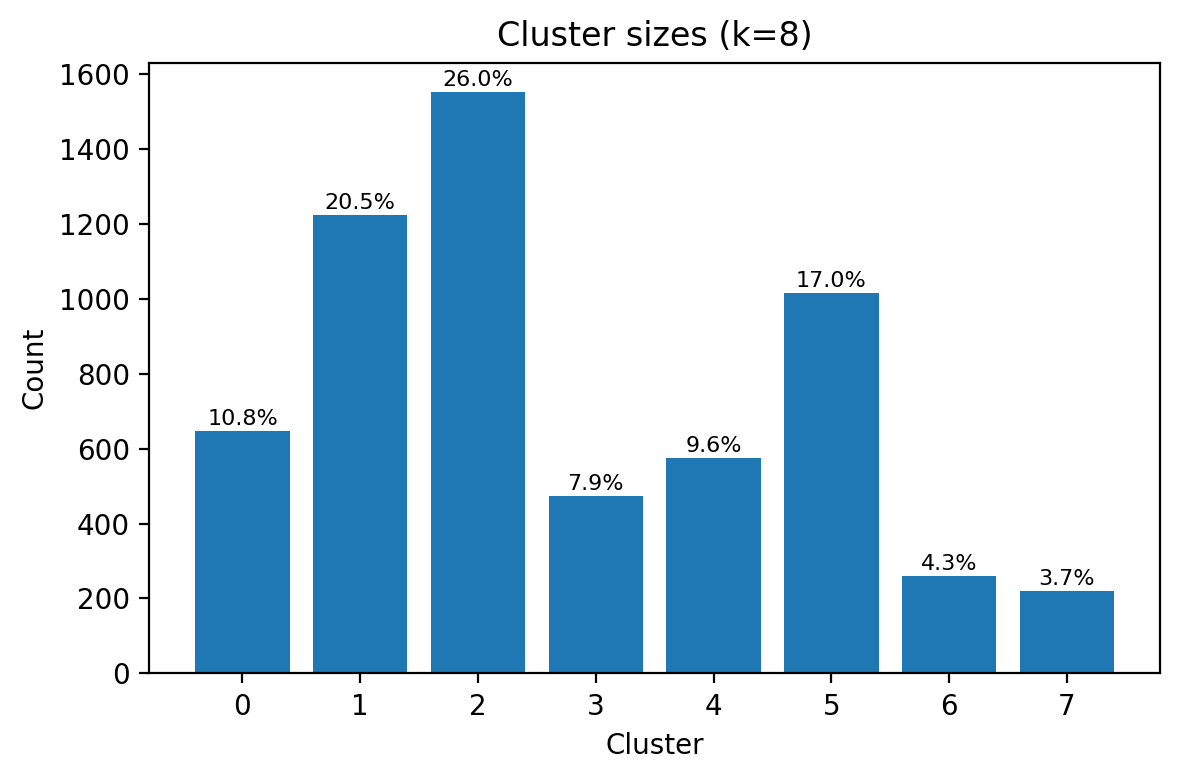

,Cluster,Count,Percent
0,0,647,10.8
1,1,1223,20.5
2,2,1552,26.0
3,3,473,7.9
4,4,575,9.6
5,5,1016,17.0
6,6,259,4.3
7,7,221,3.7


In [ ]:
sizes = CLUST.value_counts().sort_index()
sizes_pct = (sizes / sizes.sum() * 100).round(1)

# Save numeric table for the dissertation appendix
sizes_tbl = pd.DataFrame({"Cluster": sizes.index, "Count": sizes.values, "Percent": sizes_pct.values})
sizes_tbl.to_csv(f"{VIZDIR}/cluster_sizes_k8.csv", index=False)

# Bar chart
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(sizes.index.astype(str), sizes.values)
ax.set_xlabel("Cluster")
ax.set_ylabel("Count")
ax.set_title("Cluster sizes (k=8)")
for i, (x,y) in enumerate(zip(sizes.index.astype(str), sizes.values)):
    ax.text(i, y+5, f"{sizes_pct.iloc[i]}%", ha="center", va="bottom", fontsize=8)
plt.tight_layout()
plt.savefig(f"{VIZDIR}/cluster_sizes_k8.png")
plt.show()

sizes_tbl

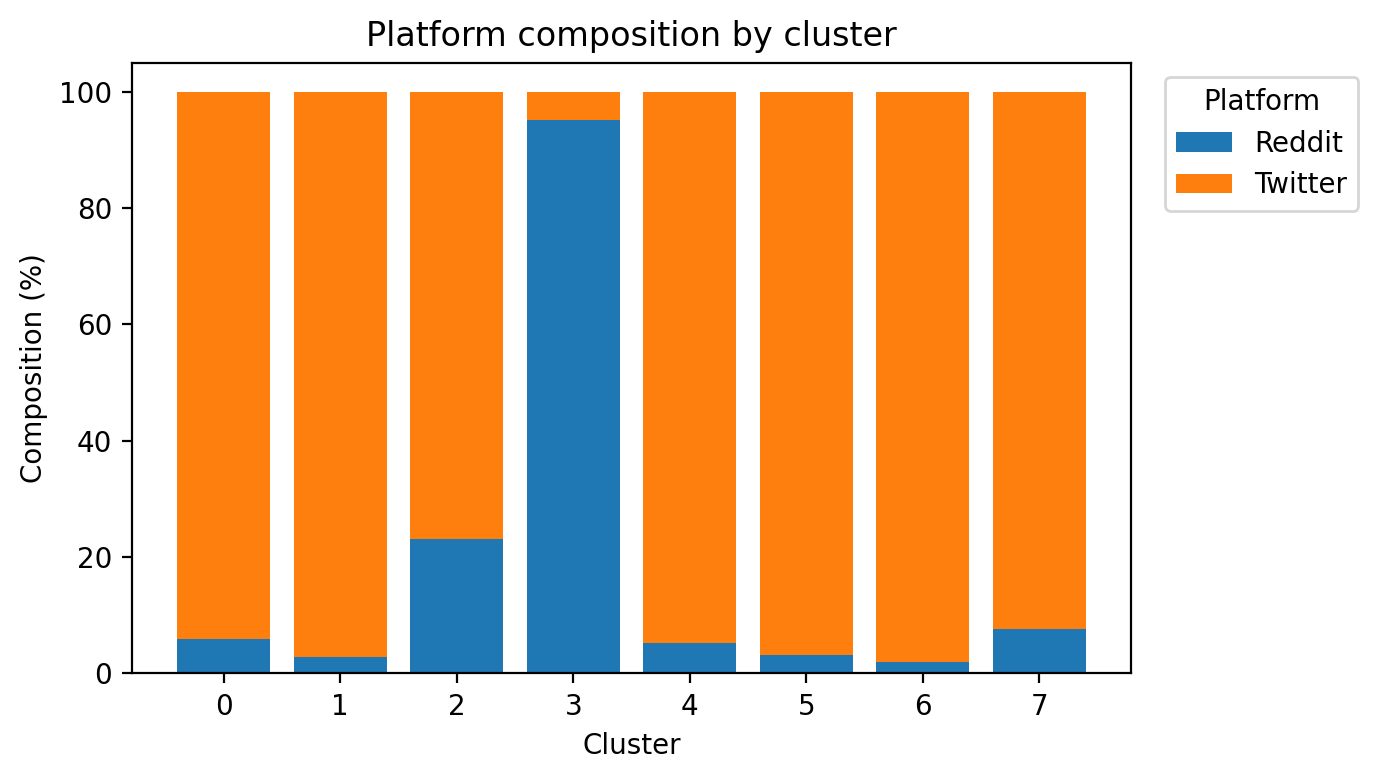

Social_Media_Type,Reddit,Twitter
Cluster_SBERT,,
0,5.9,94.1
1,2.8,97.2
2,23.2,76.8
3,95.1,4.9
4,5.2,94.8


In [ ]:
plat_ct = pd.crosstab(CLUST, df["Social_Media_Type"])
plat_pct = plat_ct.div(plat_ct.sum(axis=1), axis=0) * 100
plat_pct.to_csv(f"{VIZDIR}/platform_by_cluster_k8_pct.csv")

fig, ax = plt.subplots(figsize=(7,4))
bottom = np.zeros(len(plat_pct))
for col in plat_pct.columns:
    ax.bar(plat_pct.index.astype(str), plat_pct[col].values, bottom=bottom, label=col)
    bottom += plat_pct[col].values
ax.set_xlabel("Cluster")
ax.set_ylabel("Composition (%)")
ax.set_title("Platform composition by cluster")
ax.legend(title="Platform", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.savefig(f"{VIZDIR}/platform_by_cluster_k8.png")
plt.show()

plat_pct.round(1).head()

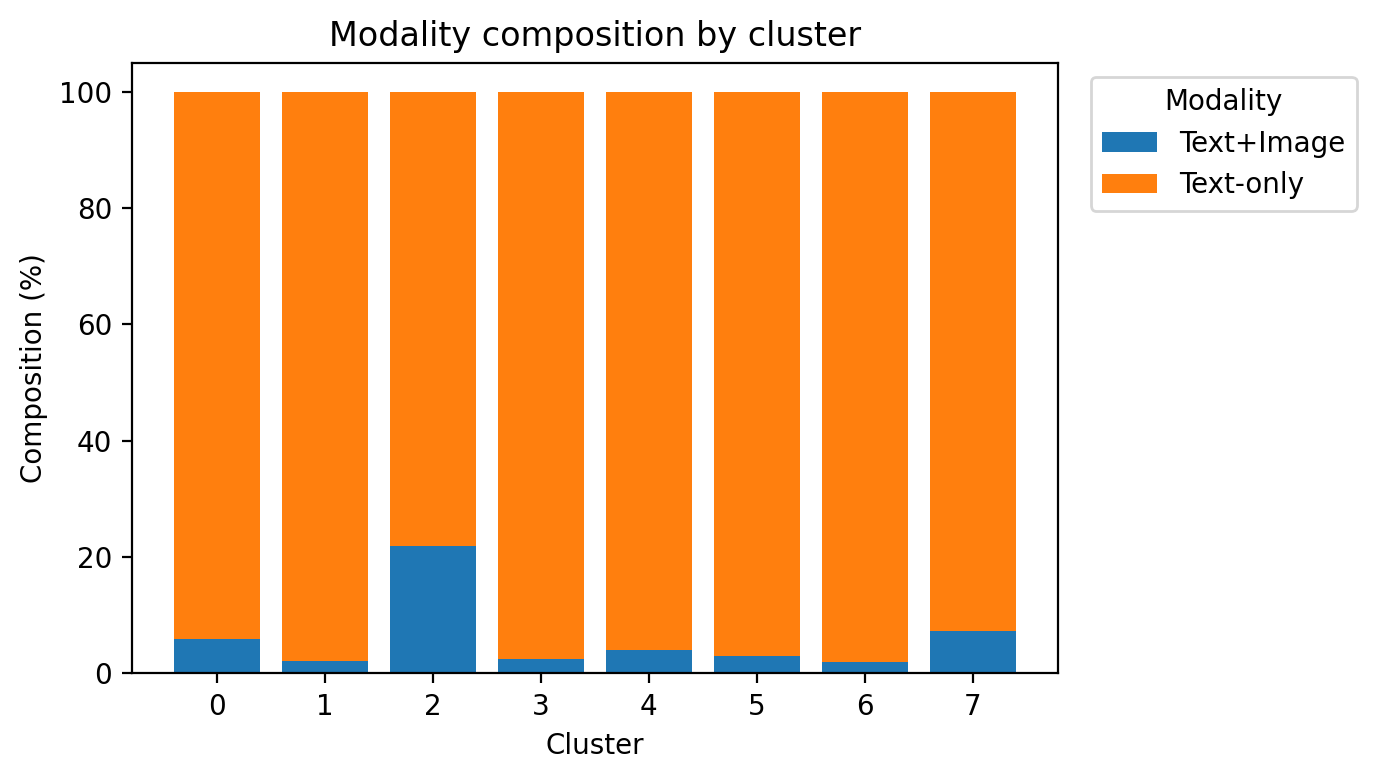

Modality_Type,Text+Image,Text-only
Cluster_SBERT,,
0,5.9,94.1
1,2.2,97.8
2,21.9,78.1
3,2.5,97.5
4,4.0,96.0


In [ ]:
mod_ct = pd.crosstab(CLUST, df["Modality_Type"])
mod_pct = mod_ct.div(mod_ct.sum(axis=1), axis=0) * 100
mod_pct.to_csv(f"{VIZDIR}/modality_by_cluster_k8_pct.csv")

fig, ax = plt.subplots(figsize=(7,4))
bottom = np.zeros(len(mod_pct))
for col in mod_pct.columns:
    ax.bar(mod_pct.index.astype(str), mod_pct[col].values, bottom=bottom, label=col)
    bottom += mod_pct[col].values
ax.set_xlabel("Cluster")
ax.set_ylabel("Composition (%)")
ax.set_title("Modality composition by cluster")
ax.legend(title="Modality", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.savefig(f"{VIZDIR}/modality_by_cluster_k8.png")
plt.show()

mod_pct.round(1).head()

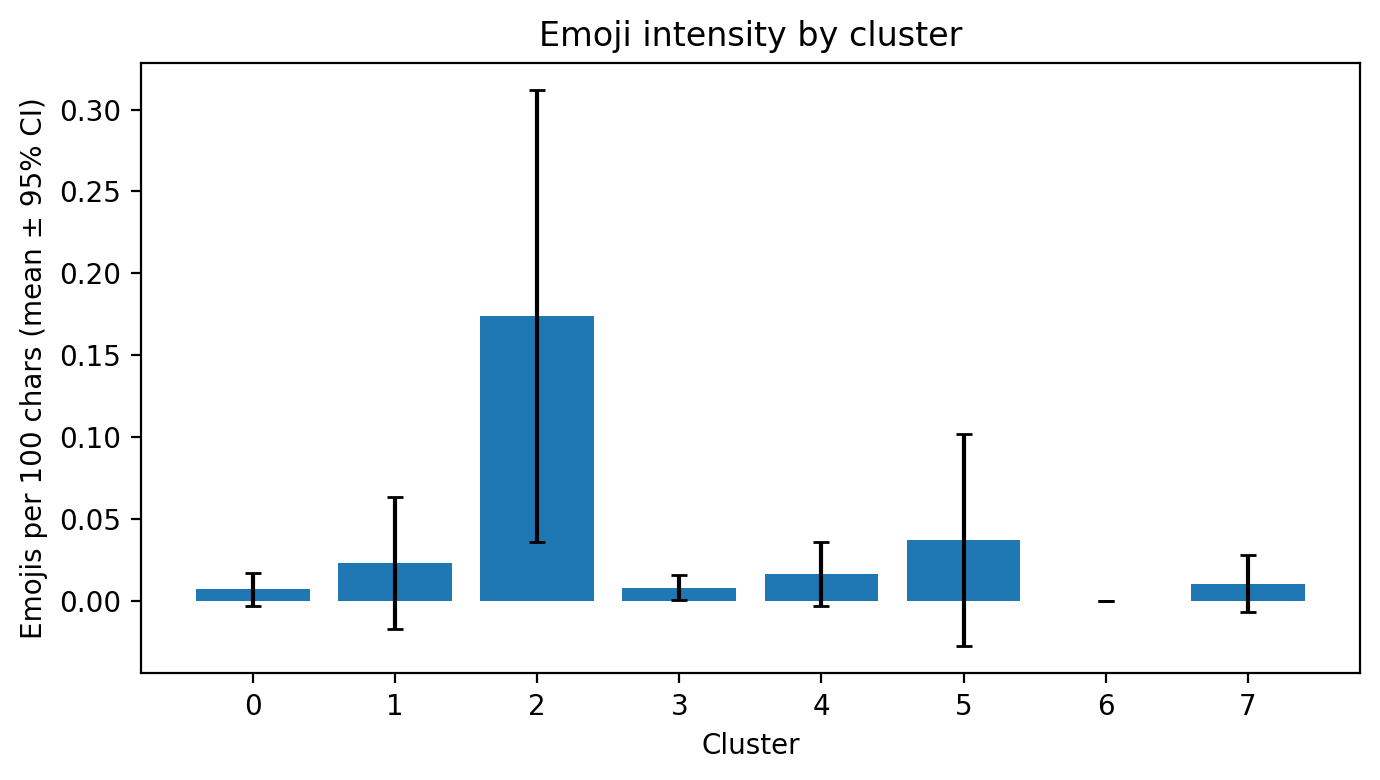

,Cluster,N,EmojiPer100_mean,EmojiPer100_ci95
0,0,647,0.007,0.010
1,1,1223,0.023,0.040
2,2,1552,0.174,0.138
3,3,473,0.008,0.008
4,4,575,0.017,0.020
5,5,1016,0.037,0.065
6,6,259,0.000,0.000
7,7,221,0.010,0.017


In [ ]:
# Compute per-cluster emoji stats
stats_rows = []
for c in sorted(df["Cluster_SBERT"].unique()):
    sub = df[df["Cluster_SBERT"]==c]
    vals = sub["emoji_per_100chars"].replace([np.inf, -np.inf], np.nan).dropna()
    mean = vals.mean() if len(vals) else 0.0
    std  = vals.std(ddof=1) if len(vals)>1 else 0.0
    n    = len(vals)
    sem  = std/np.sqrt(n) if n>0 else 0.0
    ci95 = 1.96*sem
    stats_rows.append({"Cluster": int(c), "N": n, "EmojiPer100_mean": mean, "EmojiPer100_ci95": ci95})

emoji_stats = pd.DataFrame(stats_rows).sort_values("Cluster")
emoji_stats.to_csv(f"{VIZDIR}/emoji_intensity_by_cluster.csv", index=False)

# Plot mean +/- 95% CI
fig, ax = plt.subplots(figsize=(7,4))
ax.bar(emoji_stats["Cluster"].astype(str), emoji_stats["EmojiPer100_mean"])
ax.errorbar(emoji_stats["Cluster"].astype(str), emoji_stats["EmojiPer100_mean"],
            yerr=emoji_stats["EmojiPer100_ci95"], fmt='none', ecolor='black', capsize=3)
ax.set_xlabel("Cluster"); ax.set_ylabel("Emojis per 100 chars (mean ± 95% CI)")
ax.set_title("Emoji intensity by cluster")
plt.tight_layout()
plt.savefig(f"{VIZDIR}/emoji_intensity_by_cluster.png")
plt.show()

emoji_stats.round(3)

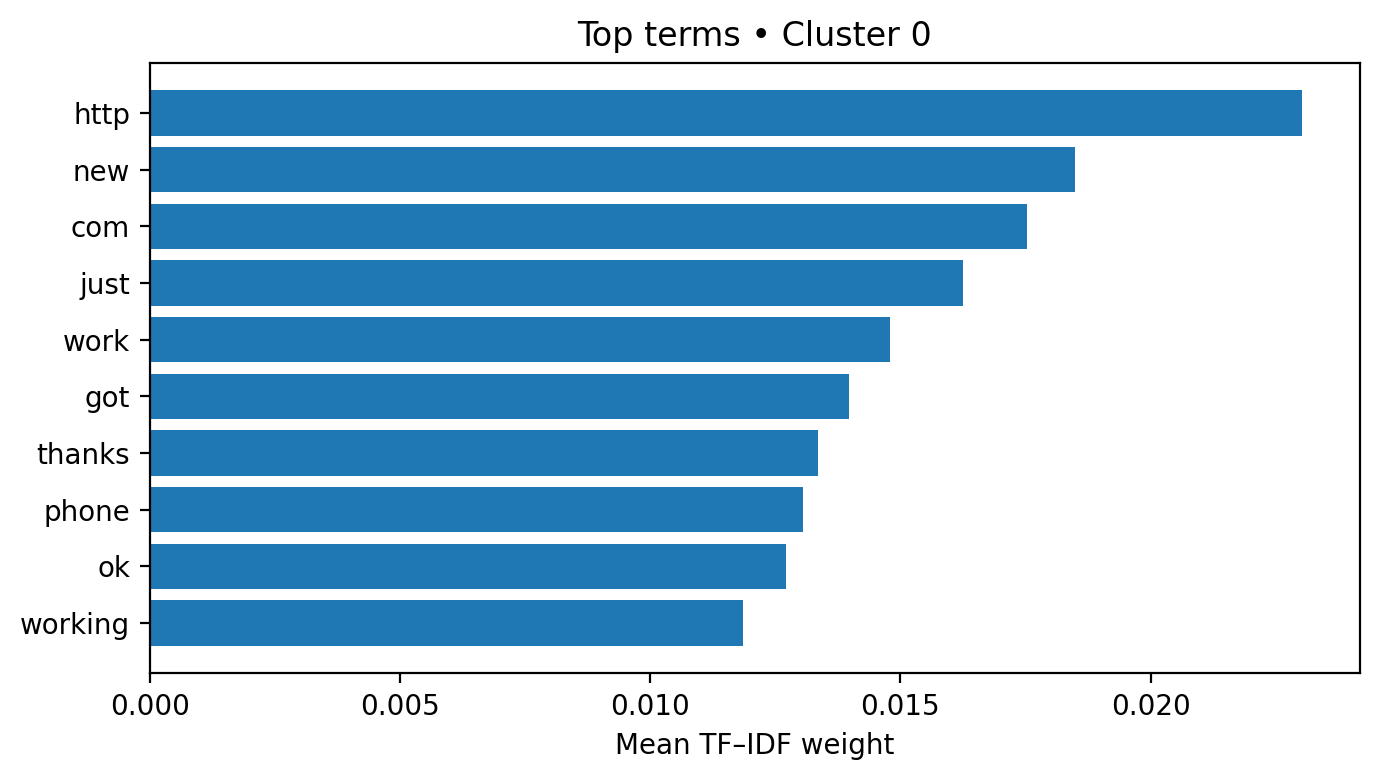

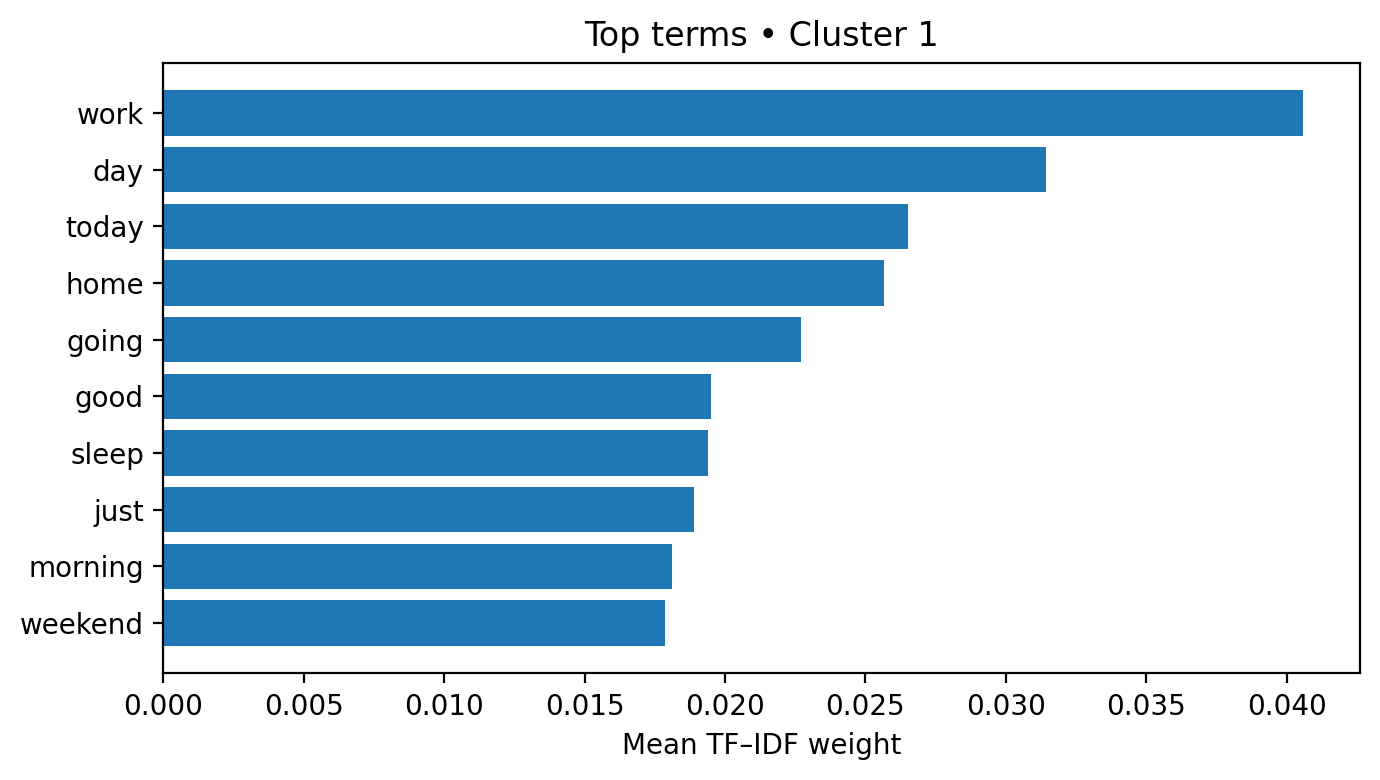

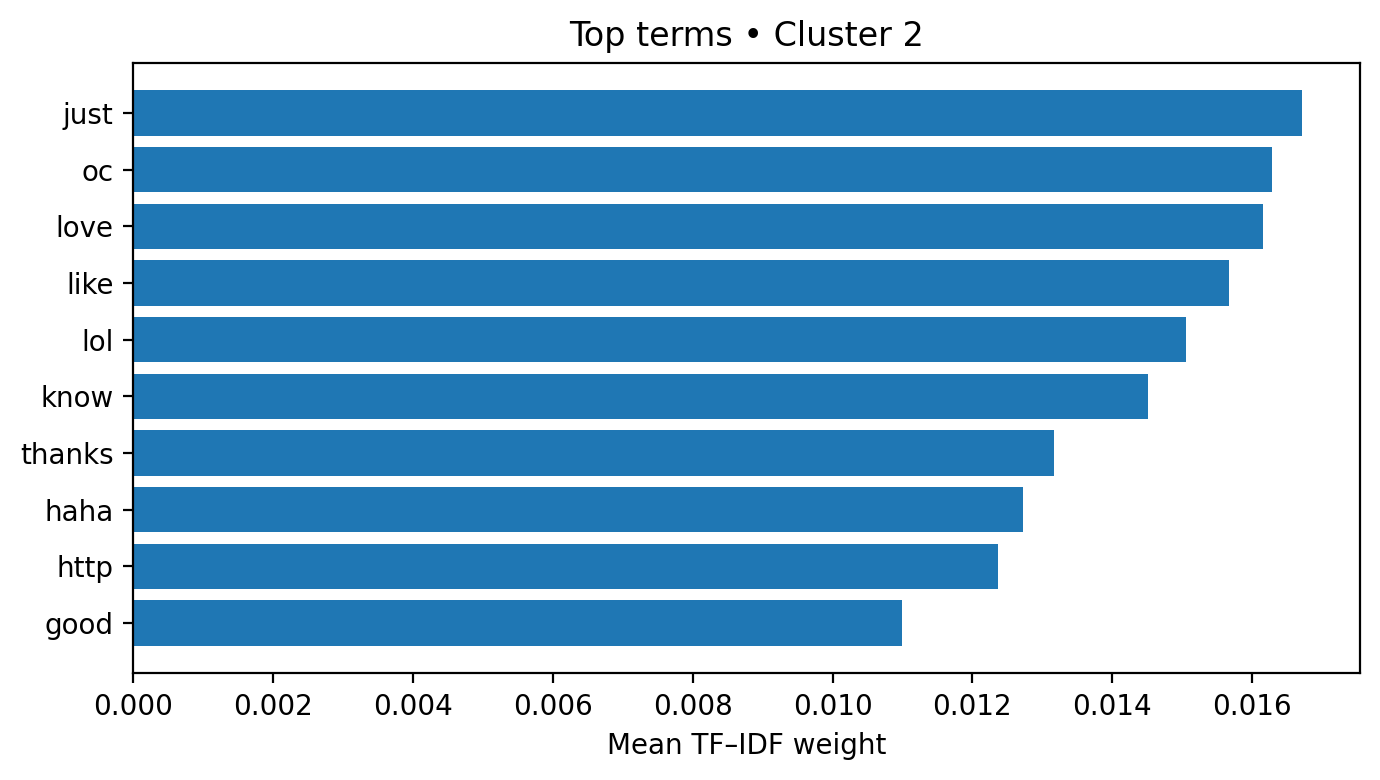

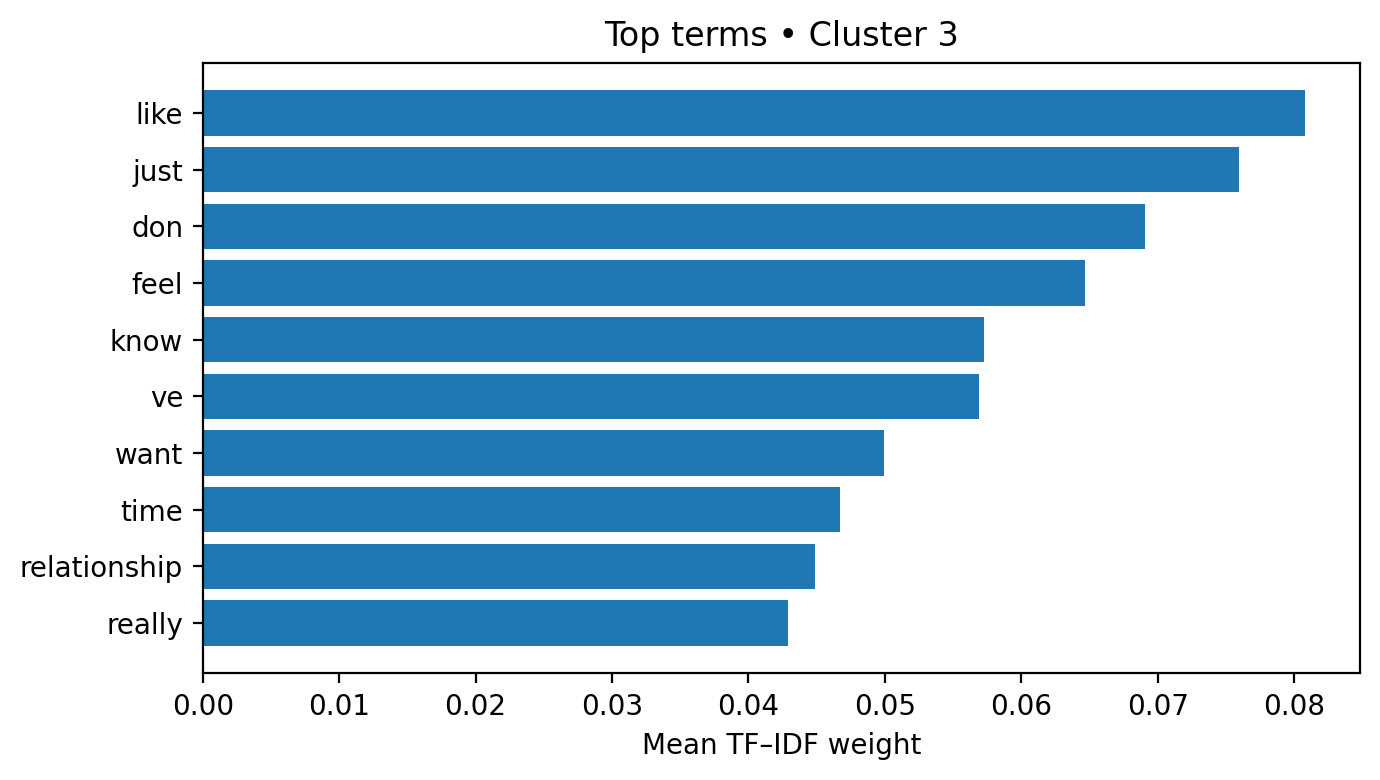

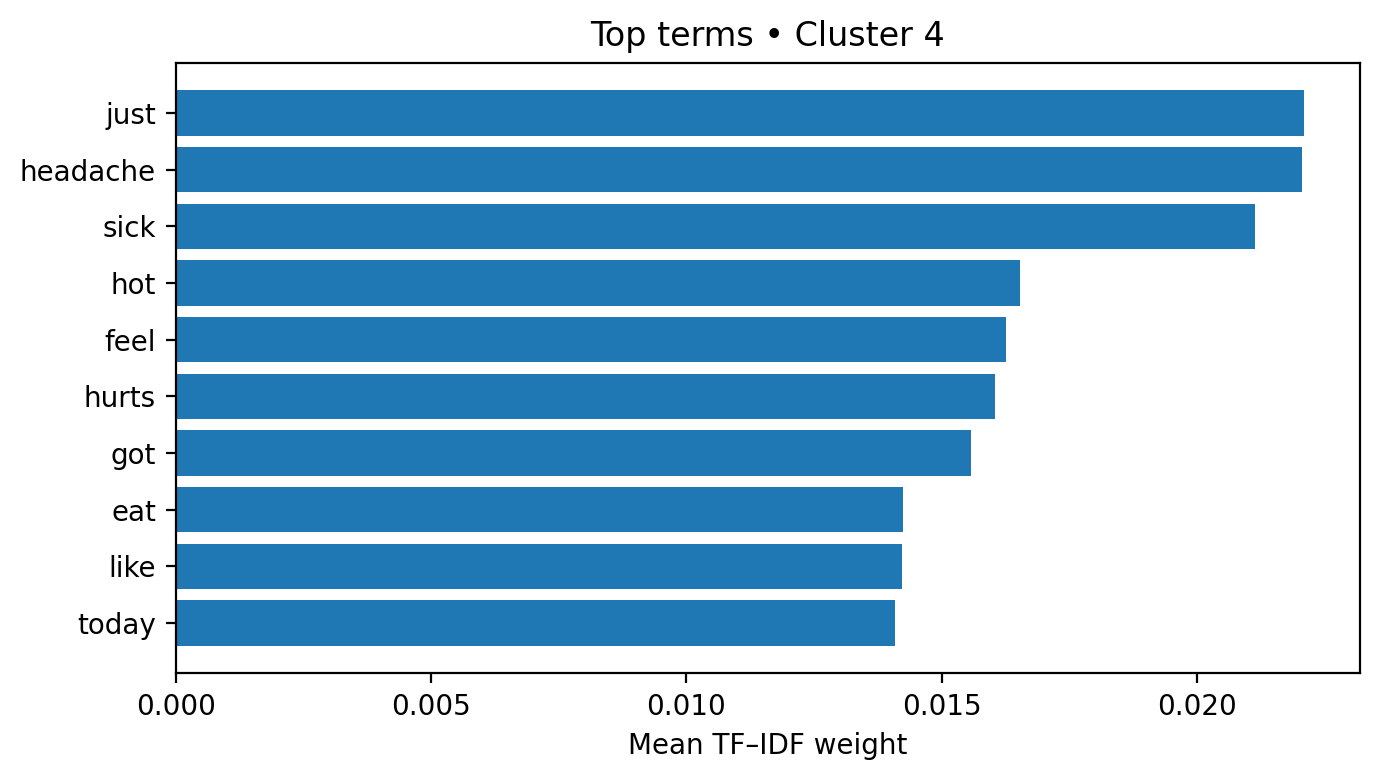

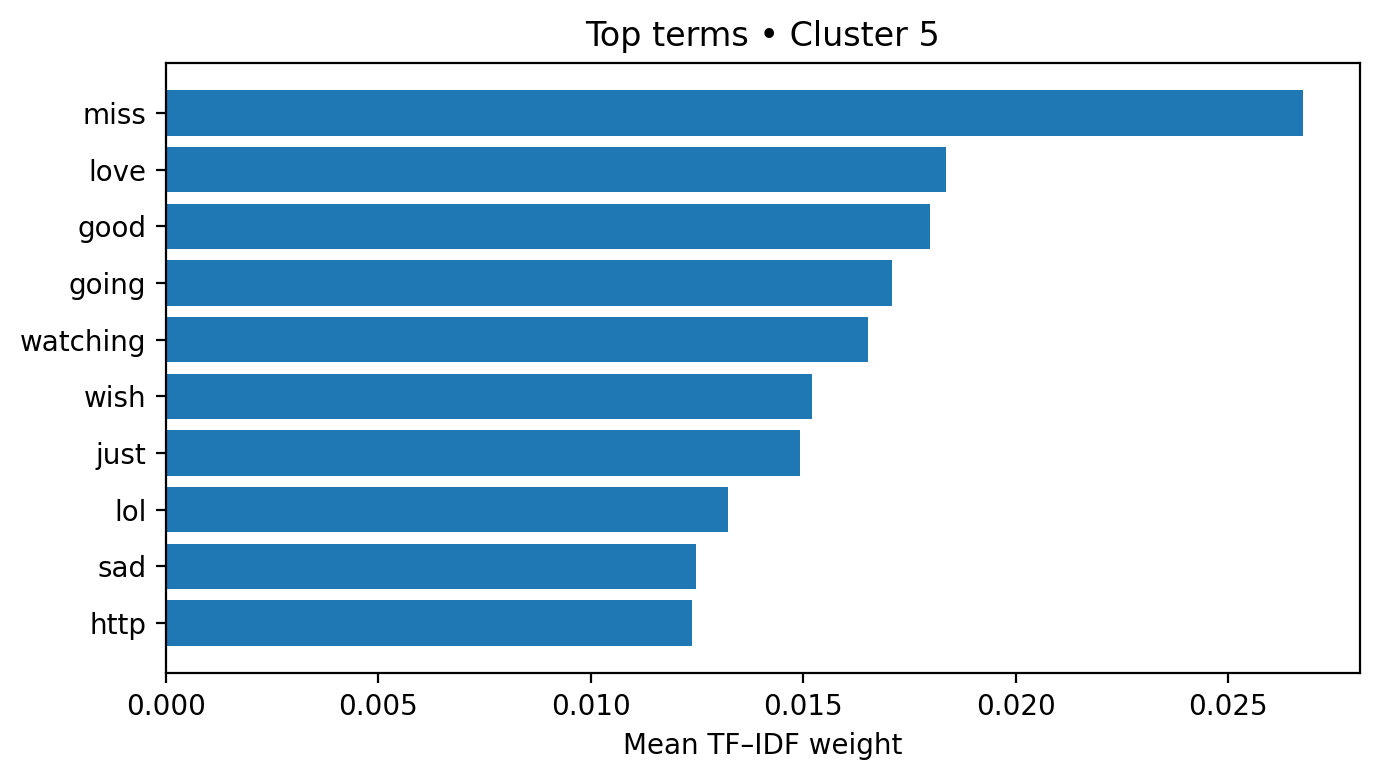

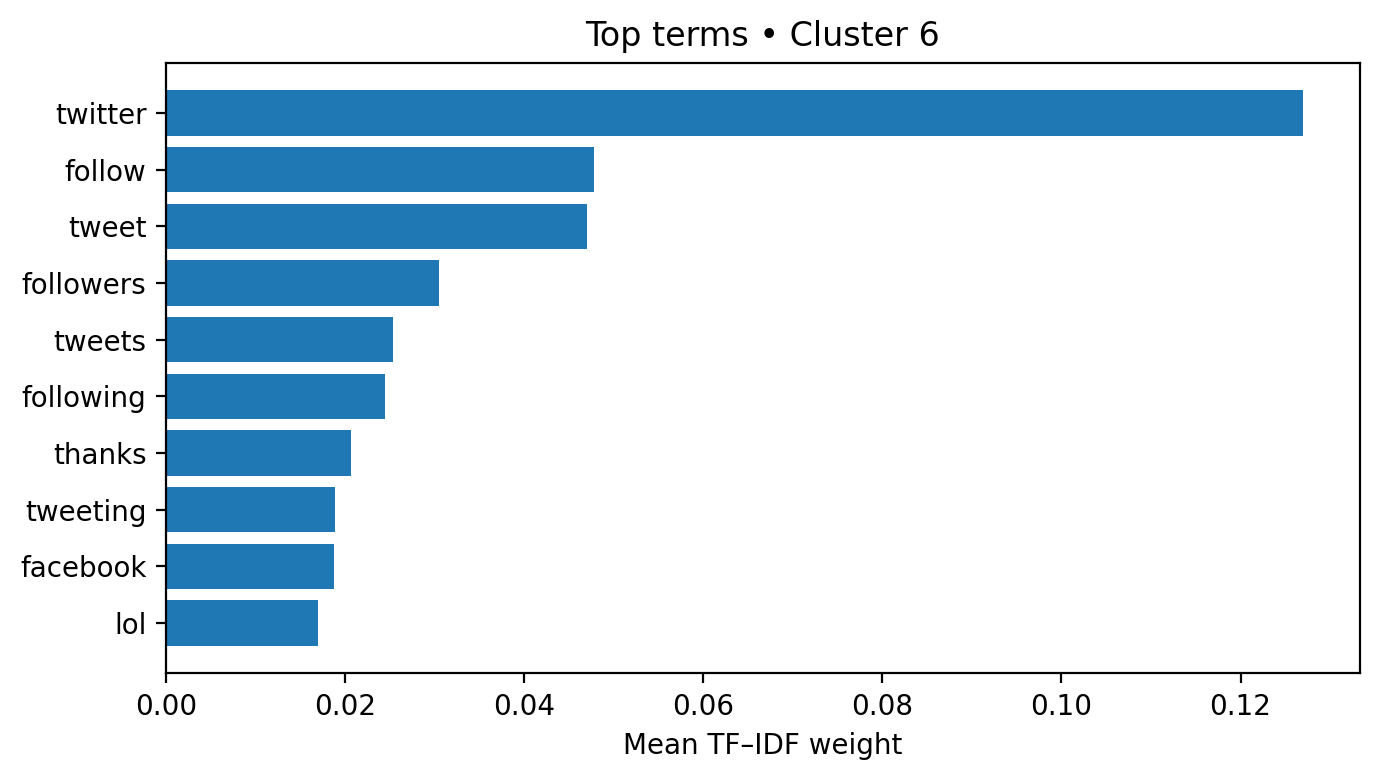

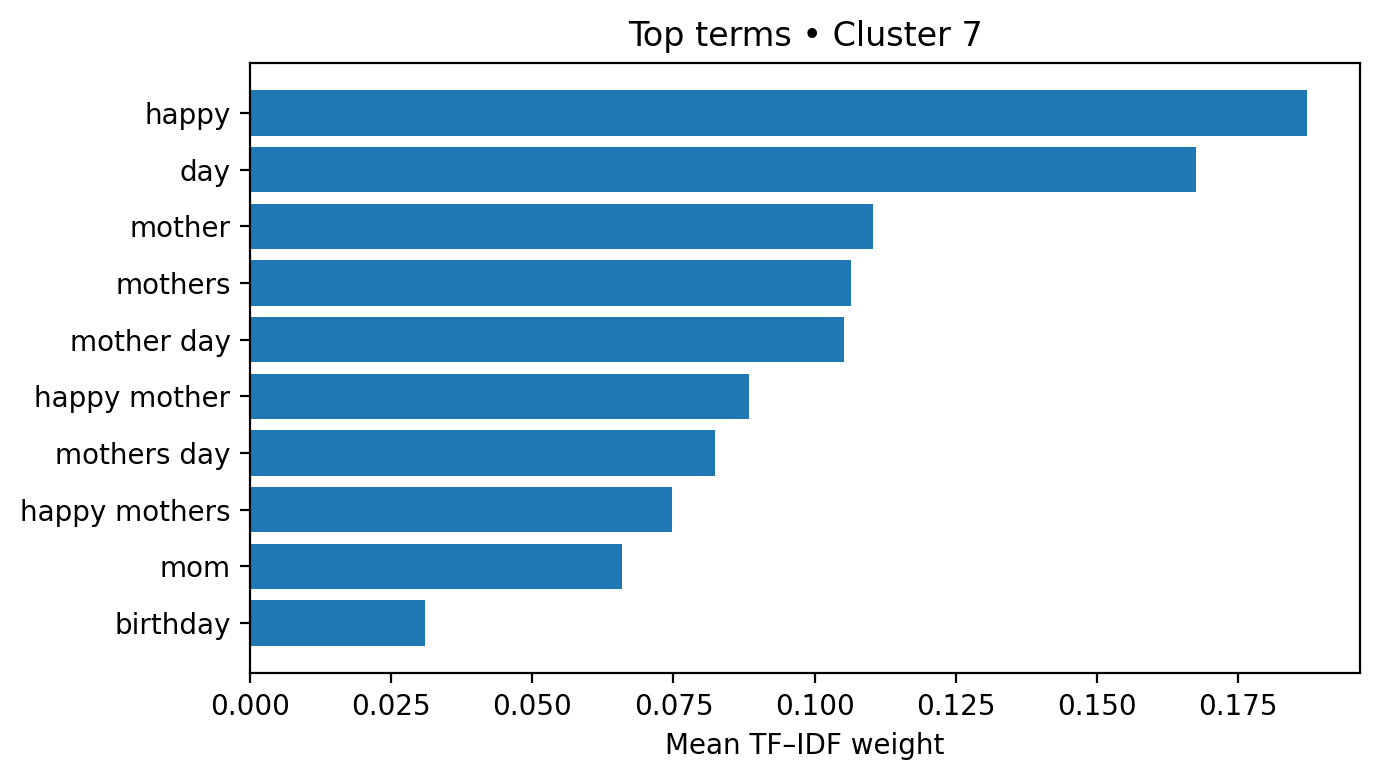

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

text = df["Text_Combined"].astype(str)
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=5, max_df=0.5, stop_words="english")
X_tfidf = tfidf.fit_transform(text)
terms = np.array(tfidf.get_feature_names_out())

TOP_K = 10

for c in sorted(df["Cluster_SBERT"].unique()):
    idx = (df["Cluster_SBERT"]==c).to_numpy(dtype=bool)
    if idx.sum() == 0:
        continue
    mean_w = X_tfidf[idx].mean(axis=0).A1
    top_idx = np.argsort(mean_w)[::-1][:TOP_K]
    top_terms = terms[top_idx]
    top_vals  = mean_w[top_idx]

    # Save table
    pd.DataFrame({"term": top_terms, "weight": top_vals}).to_csv(
        f"{VIZDIR}/cluster_{c}_top_terms.csv", index=False
    )

    # Plot horizontal bars
    fig, ax = plt.subplots(figsize=(7,4))
    y = np.arange(len(top_terms))
    ax.barh(y, top_vals)
    ax.set_yticks(y); ax.set_yticklabels(top_terms)
    ax.invert_yaxis()
    ax.set_xlabel("Mean TF–IDF weight"); ax.set_title(f"Top terms • Cluster {c}")
    plt.tight_layout()
    plt.savefig(f"{VIZDIR}/cluster_{c}_top_terms.png")
    plt.show()

In [ ]:
import numpy as np
import pandas as pd

# Reuse TF-IDF objects and df from earlier
# tfidf_matrix, terms, df, etc.

distinctiveness = []
top_k = 10  # look at top 10 terms per cluster

for c in sorted(df["Cluster_SBERT"].dropna().unique().astype(int)):
    idx = (df["Cluster_SBERT"] == c).to_numpy(dtype=bool)
    if idx.sum() == 0:
        continue

    # mean TF-IDF vector for this cluster
    mean_vec = tfidf_matrix[idx].mean(axis=0).A1

    # global average across all docs
    global_vec = tfidf_matrix.mean(axis=0).A1

    # top-k terms for this cluster
    top_idx = np.argsort(mean_vec - global_vec)[::-1][:top_k]
    top_terms = terms[top_idx]
    diffs = (mean_vec - global_vec)[top_idx]

    distinctiveness.append({
        "Cluster": c,
        "TopTerms": ", ".join(top_terms),
        "MeanDiff": np.mean(diffs),  # average distinctiveness gain
        "MaxDiff": np.max(diffs)     # single most distinctive term
    })

disc_df = pd.DataFrame(distinctiveness)
disc_df.to_csv(os.path.join(OUT_DIR, "cluster_distinctiveness.csv"), index=False)
disc_df

,Cluster,TopTerms,MeanDiff,MaxDiff
0,0,"http, new, link, phone, com, iphone, use, inte...",0.009030,0.012619
1,1,"work, home, today, sleep, day, weekend, mornin...",0.013981,0.026606
2,2,"oc, haha, thanks, lol, twitpic, twitpic com, h...",0.004964,0.011171
3,3,"like, don, feel, just, ve, know, relationship,...",0.046853,0.063448
4,4,"headache, sick, hurts, hot, eat, food, hungry,...",0.012461,0.019369
5,5,"miss, watching, song, movie, wish, watch, miss...",0.008809,0.019041
6,6,"twitter, follow, tweet, followers, tweets, fol...",0.034944,0.120882
7,7,"happy, day, mother, mothers, mother day, happy...",0.096061,0.176928


In [ ]:
# Concise profile table
profile_rows = []
for c in sorted(df["Cluster_SBERT"].unique()):
    sub = df[df["Cluster_SBERT"]==c]
    # platform/modality mix %
    plat = (sub["Social_Media_Type"].value_counts(normalize=True)*100).round(1).to_dict()
    mod  = (sub["Modality_Type"].value_counts(normalize=True)*100).round(1).to_dict()
    # top 6 terms (for compactness)
    idx = (df["Cluster_SBERT"]==c).to_numpy(dtype=bool)
    mean_w = X_tfidf[idx].mean(axis=0).A1
    top_idx = np.argsort(mean_w)[::-1][:6]
    top_terms = ", ".join(terms[top_idx])
    # emoji
    mean_emoji = sub["emoji_per_100chars"].replace([np.inf, -np.inf], np.nan).mean()
    profile_rows.append({
        "Cluster": int(c),
        "Size": len(sub),
        "Twitter%": plat.get("Twitter", 0.0),
        "Reddit%":  plat.get("Reddit", 0.0),
        "Text-only%": mod.get("Text-only", 0.0),
        "Text+Image%": mod.get("Text+Image", 0.0),
        "Image-only%": mod.get("Image-only", 0.0),
        "Emoji/100 (mean)": round(mean_emoji or 0.0, 3),
        "Top terms (short)": top_terms
    })
profiles_short = pd.DataFrame(profile_rows).sort_values("Cluster")
profiles_short.to_csv(f"{VIZDIR}/cluster_profiles_short.csv", index=False)
profiles_short

,Cluster,Size,Twitter%,Reddit%,Text-only%,Text+Image%,Image-only%,Emoji/100 (mean),Top terms (short)
0,0,647,94.1,5.9,94.1,5.9,0.0,0.007,"http, new, com, just, work, got"
1,1,1223,97.2,2.8,97.8,2.2,0.0,0.023,"work, day, today, home, going, good"
2,2,1552,76.8,23.2,78.1,21.9,0.0,0.174,"just, oc, love, like, lol, know"
3,3,473,4.9,95.1,97.5,2.5,0.0,0.008,"like, just, don, feel, know, ve"
4,4,575,94.8,5.2,96.0,4.0,0.0,0.017,"just, headache, sick, hot, feel, hurts"
5,5,1016,96.9,3.1,97.0,3.0,0.0,0.037,"miss, love, good, going, watching, wish"
6,6,259,98.1,1.9,98.1,1.9,0.0,0.000,"twitter, follow, tweet, followers, tweets, fol..."
7,7,221,92.3,7.7,92.8,7.2,0.0,0.010,"happy, day, mother, mothers, mother day, happy..."


(4.2.4) Cluster polarity check with VADER

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


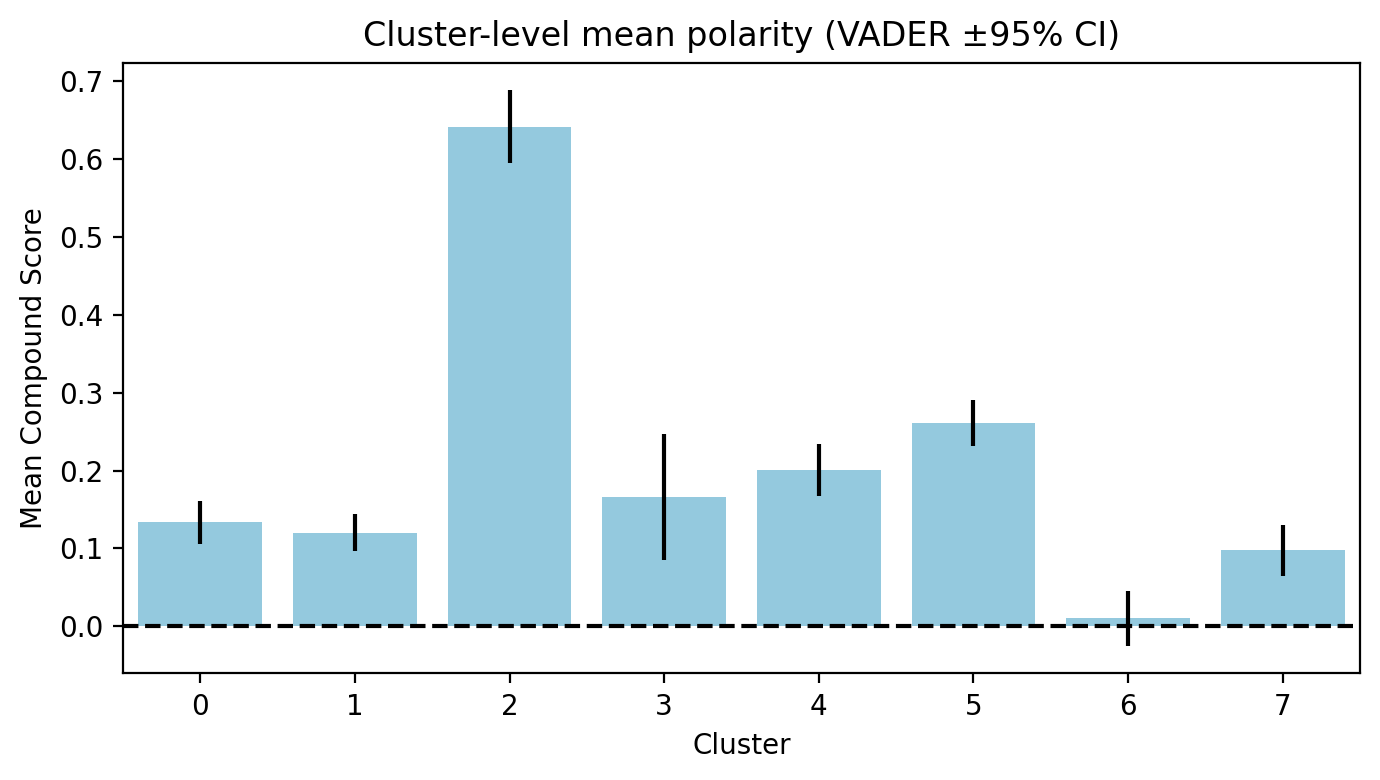

,mean,std,count,sem,ci95
Cluster_SBERT,,,,,
0,0.133704,0.419796,888,0.014087,0.027611
1,0.120466,0.457523,1395,0.012250,0.024009
2,0.641531,0.297774,157,0.023765,0.046579
3,0.166096,0.860139,437,0.041146,0.080646
4,0.200644,0.477978,796,0.016941,0.033205
5,0.260906,0.451900,899,0.015072,0.029541
6,0.010189,0.452665,644,0.017837,0.034961
7,0.097920,0.457502,750,0.016706,0.032743


In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# make sure you have NLTK VADER
import nltk
nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()

# Load clustered dataset
DATA = "/content/drive/MyDrive/msc_final_dataset/chapter4_results/final_with_clusters_k8.csv"
df = pd.read_csv(DATA)

# Ensure cluster col exists
if "Cluster_SBERT_k8" in df.columns:
    df["Cluster_SBERT"] = df["Cluster_SBERT_k8"]

# Run VADER
df["VADER"] = df["Text_Combined"].astype(str).fillna("").apply(lambda x: sia.polarity_scores(x)["compound"])

# Aggregate by cluster
polarity_stats = df.groupby("Cluster_SBERT")["VADER"].agg(["mean","std","count"])
polarity_stats["sem"] = polarity_stats["std"]/np.sqrt(polarity_stats["count"])
polarity_stats["ci95"] = 1.96 * polarity_stats["sem"]

# Plot
plt.figure(figsize=(7,4))
sns.barplot(x=polarity_stats.index, y=polarity_stats["mean"], yerr=polarity_stats["ci95"], color="skyblue")
plt.axhline(0, color="black", linestyle="--")
plt.title("Cluster-level mean polarity (VADER ±95% CI)")
plt.xlabel("Cluster"); plt.ylabel("Mean Compound Score")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/msc_final_dataset/chapter4_results/cluster_polarity.png", dpi=250)
plt.show()

polarity_stats

Mapping clusters to Plutchik emotions with SBERT synonyms made

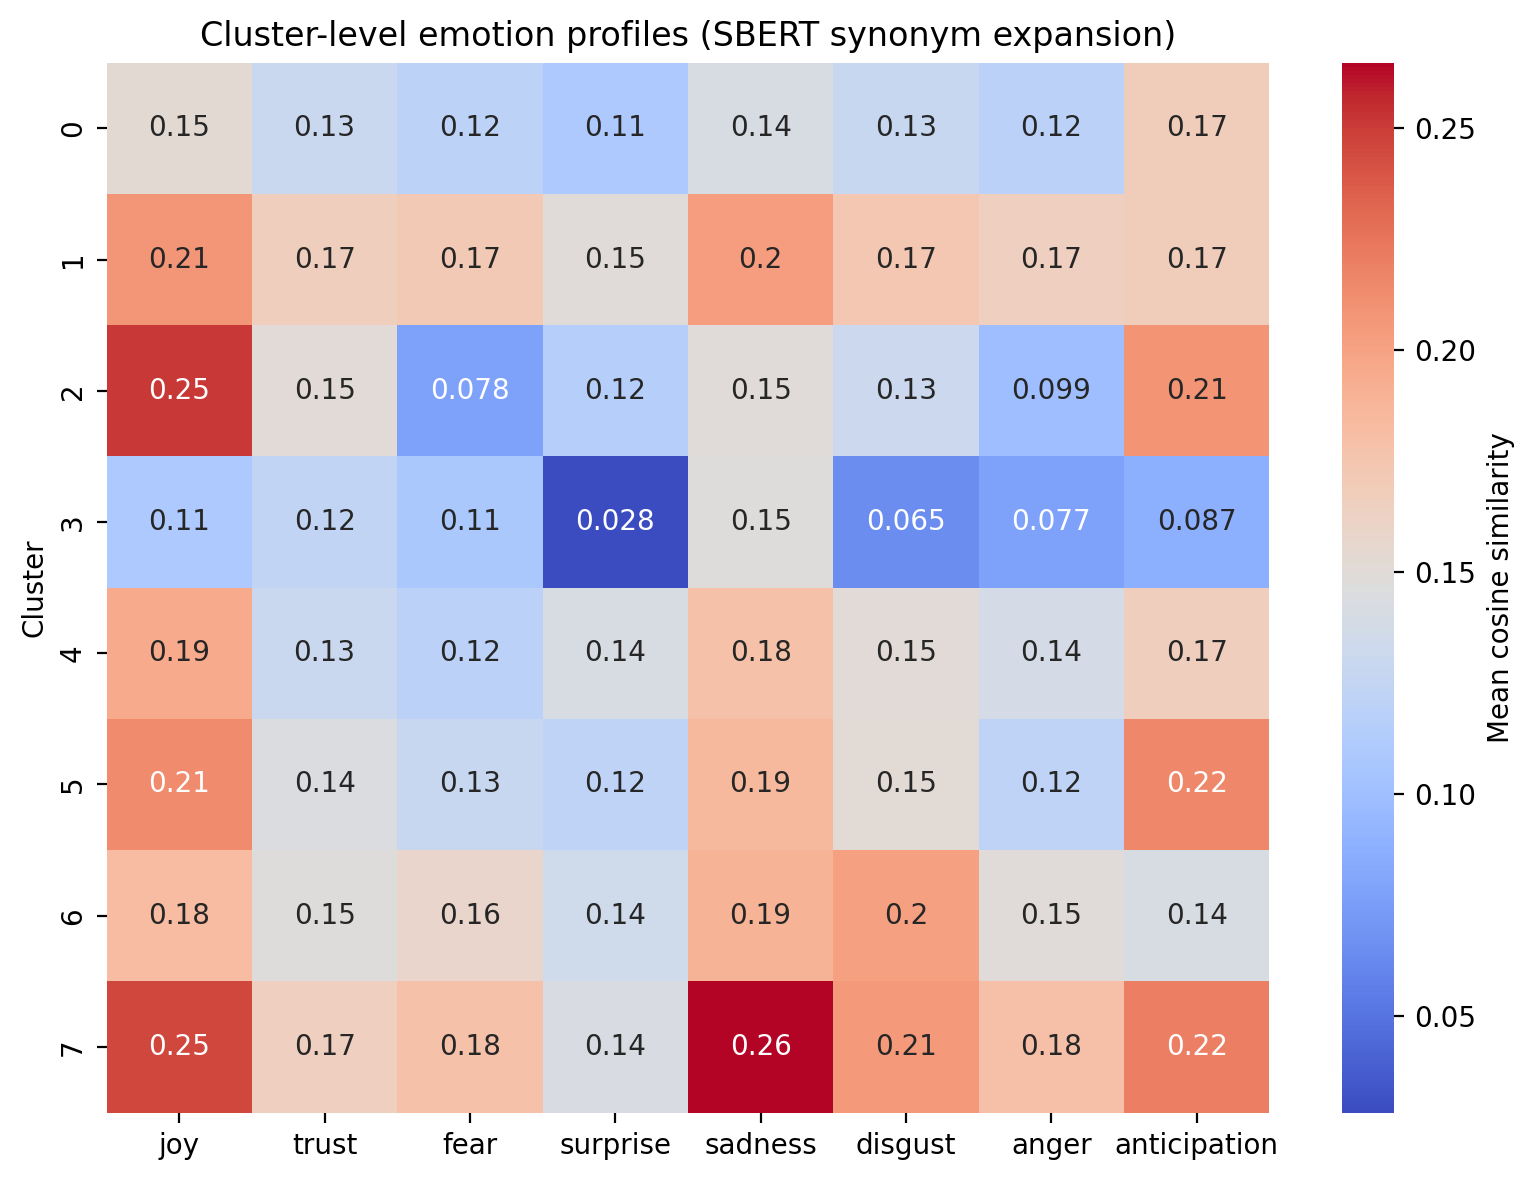

,joy,trust,fear,surprise,sadness,disgust,anger,anticipation
Cluster,,,,,,,,
0,0.152781,0.130777,0.120211,0.109374,0.141584,0.128564,0.119705,0.167436
1,0.207657,0.166474,0.172287,0.149755,0.203030,0.173916,0.165854,0.167396
2,0.251664,0.150424,0.078180,0.115393,0.149566,0.130952,0.098777,0.208559
3,0.109128,0.123989,0.108661,0.028374,0.147527,0.064502,0.077439,0.086654
4,0.194822,0.130533,0.119029,0.141837,0.178097,0.150877,0.139043,0.166012
5,0.213476,0.143982,0.128371,0.122218,0.185119,0.151779,0.122379,0.215756
6,0.183163,0.147888,0.158483,0.135208,0.189450,0.201203,0.149808,0.141420
7,0.245793,0.165442,0.178082,0.142348,0.264690,0.205369,0.179518,0.220153


In [ ]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

# SBERT model already used for embeddings
model = SentenceTransformer("all-mpnet-base-v2")

# Define Plutchik seed words
seed_words = {
    "joy": ["happy","joy","glad","excited","love"],
    "trust": ["trust","safe","secure","faith"],
    "fear": ["fear","scared","afraid","worried"],
    "surprise": ["surprised","shocked","unexpected","amazed"],
    "sadness": ["sad","unhappy","cry","depressed","lonely"],
    "disgust": ["disgust","gross","nasty","sick","hate"],
    "anger": ["angry","mad","furious","annoyed"],
    "anticipation": ["hopeful","expect","waiting","looking forward"],
}

# Embed seed words
emotion_embs = {emo: model.encode(words, normalize_embeddings=True) for emo, words in seed_words.items()}

#find sbert embeddings from posts
X = np.load("/content/drive/MyDrive/msc_final_dataset/chapter4_results/sbert_embeddings.npy")

# Compute cosine similarity: each post vs each emotion seed
def post_to_emotion_vector(text_emb):
    sims = {emo: float(util.cos_sim(text_emb, embs).max()) for emo, embs in emotion_embs.items()}
    return sims

# For speed, batch
cluster_profiles = []
for c in sorted(df["Cluster_SBERT"].unique()):
    idx = df["Cluster_SBERT"] == c
    Xc = X[idx]
    sims = [post_to_emotion_vector(vec) for vec in Xc]
    emo_means = {emo: np.mean([s[emo] for s in sims]) for emo in seed_words}
    emo_means["Cluster"] = c
    cluster_profiles.append(emo_means)

emo_df = pd.DataFrame(cluster_profiles).set_index("Cluster")

# draw Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(emo_df, annot=True, cmap="coolwarm", cbar_kws={'label': 'Mean cosine similarity'})
plt.title("Cluster-level emotion profiles (SBERT synonym expansion)")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/msc_final_dataset/chapter4_results/cluster_emotion_heatmap.png", dpi=250)
plt.show()

emo_df

Do a quick emoji check (to match emojis to emotion)

<Figure size 1600x800 with 0 Axes>

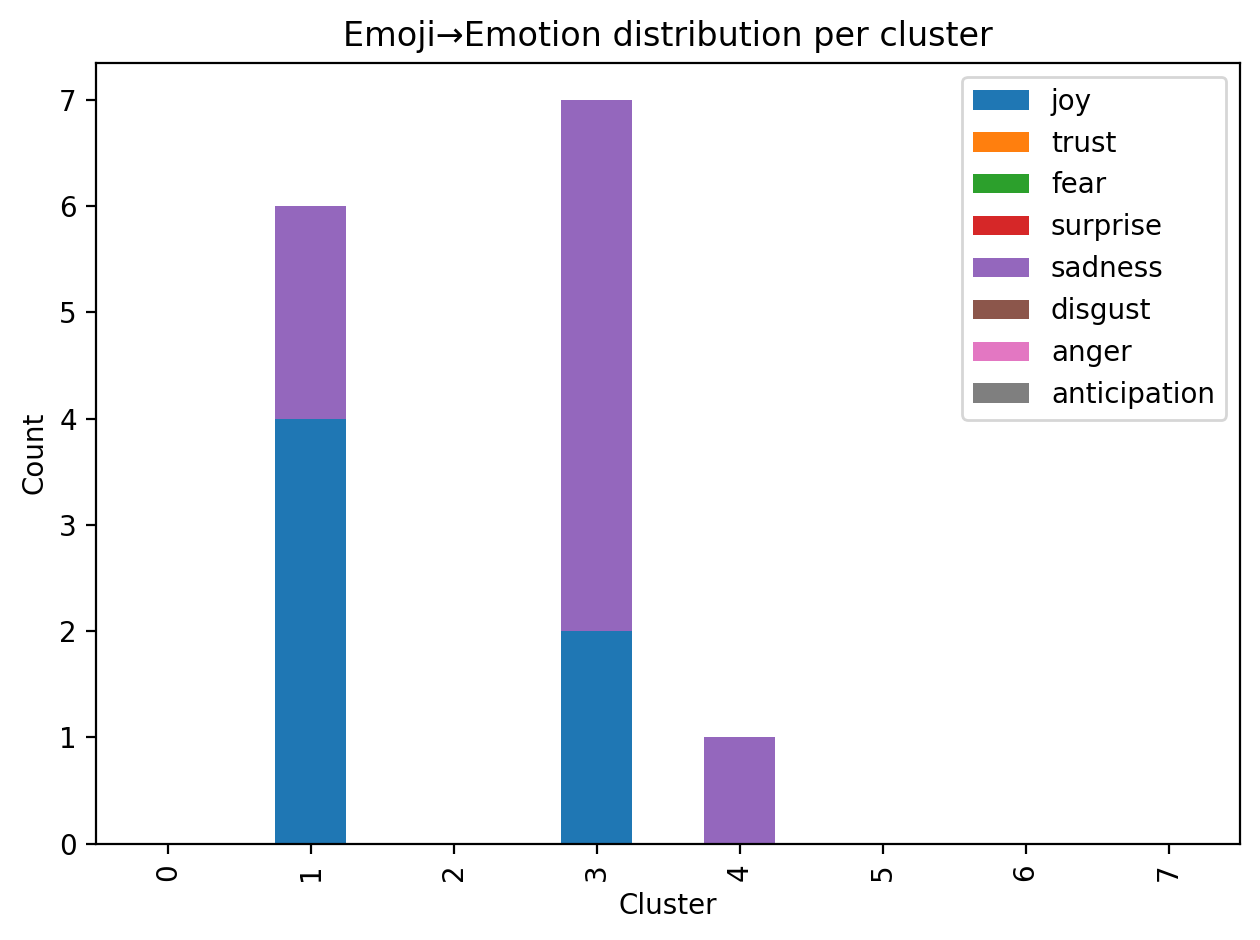

,joy,trust,fear,surprise,sadness,disgust,anger,anticipation
Cluster,,,,,,,,
0,0,0,0,0,0,0,0,0
1,4,0,0,0,2,0,0,0
2,0,0,0,0,0,0,0,0
3,2,0,0,0,5,0,0,0
4,0,0,0,0,1,0,0,0
5,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0


In [ ]:
emoji_map = {
    "😂":"joy","😆":"joy","😭":"sadness","😢":"sadness",
    "😡":"anger","🤢":"disgust","🥳":"anticipation","😱":"fear"
}
def map_emojis(e_str):
    counts = {emo:0 for emo in seed_words}
    for ch in str(e_str):
        if ch in emoji_map:
            counts[emoji_map[ch]] += 1
    return counts

emo_counts = []
for c in sorted(df["Cluster_SBERT"].unique()):
    idx = df["Cluster_SBERT"]==c
    mapped = df.loc[idx,"Emoji"].dropna().apply(map_emojis)
    cluster_total = {emo:0 for emo in seed_words}
    for d in mapped:
        for k,v in d.items(): cluster_total[k]+=v
    cluster_total["Cluster"]=c
    emo_counts.append(cluster_total)

emo_counts_df = pd.DataFrame(emo_counts).set_index("Cluster")

plt.figure(figsize=(8,4))
emo_counts_df.plot(kind="bar", stacked=True)
plt.title("Emoji→Emotion distribution per cluster")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/msc_final_dataset/chapter4_results/emoji_emotion_clusters.png", dpi=250)
plt.show()

emo_counts_df

Expanding Emotion Profiling:

In [ ]:
# 4.2.5 section
import os, json, re, math, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# env. setup (remember to reuse outputs)

BASE = "/content/drive/MyDrive/msc_final_dataset"
RES  = os.path.join(BASE, "chapter4_results")
VAL = os.path.join(RES, "validation")
os.makedirs(VAL, exist_ok=True)

DATA = os.path.join(RES, "final_with_clusters_k8.csv")
assert os.path.exists(DATA), f"Missing: {DATA}"
df = pd.read_csv(DATA)

# Use your existing cluster column
if "Cluster_SBERT" not in df.columns and "Cluster_SBERT_k8" in df.columns:
    df["Cluster_SBERT"] = df["Cluster_SBERT_k8"]
df["Cluster_SBERT"] = df["Cluster_SBERT"].astype("Int64")

# Detect embeddings file you already saved
EMB_CANDIDATES = [
    os.path.join(RES, "sbert_embeddings.npy"),
    os.path.join(BASE, "chapter4_outputs", "sbert_all_mpnet_base_v2_norm.npy"),
]
EMB = next((p for p in EMB_CANDIDATES if os.path.exists(p)), None)
if EMB is None:
    raise FileNotFoundError("SBERT embeddings not found in expected locations.")
X = np.load(EMB)  # shape: (N, 768), ideally normalized

# Ensure combined text exists
if "Text_Combined" not in df.columns:
    t = df.get("Text","").astype(str).fillna("")
    o = df.get("OCR_Text","").astype(str).fillna("")
    df["Text_Combined"] = (t + " " + o).str.strip()

texts = df["Text_Combined"].astype(str).tolist()

In [ ]:
# pt.1 - Plutchik emotions AND synonym expansion (seed sets)

seed_dict = {
    "joy":         ["joy", "happy", "happiness", "glad", "delighted", "cheerful"],
    "trust":       ["trust", "reassured", "secure", "confidence", "reliable"],
    "fear":        ["fear", "afraid", "anxious", "scared", "terrified", "panic"],
    "surprise":    ["surprise", "astonished", "shocked", "amazed", "unexpected"],
    "sadness":     ["sadness", "sad", "down", "depressed", "sorrow", "heartbroken"],
    "disgust":     ["disgust", "gross", "revolted", "nauseated", "repulsed"],
    "anger":       ["anger", "angry", "furious", "irritated", "outraged"],
    "anticipation":["anticipation", "eager", "excited", "hopeful", "expectant"]
}
emotions = list(seed_dict.keys())

# Load the same SBERT model you used for embeddings
model_name = "sentence-transformers/all-mpnet-base-v2"
model = SentenceTransformer(model_name)

# Build centroid per emotion from seed synonyms
seed_texts = sum([v for v in seed_dict.values()], [])
seed_embs  = model.encode(seed_texts, batch_size=32, normalize_embeddings=True, show_progress_bar=False)

# Map each emotion to its mean embedding
start = 0
centroids = {}
for emo in emotions:
    terms = seed_dict[emo]
    end = start + len(terms)
    centroids[emo] = seed_embs[start:end].mean(axis=0, keepdims=True)  # (1,768)
    start = end

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# PT.2 - assign per-post cosine similarity to emotion seeds

# If X is normalized, cosine = dot product.
S = {}
for emo in emotions:
    S[emo] = (X @ centroids[emo].T).ravel()  # (N,)

S_df = pd.DataFrame(S)
S_df.columns = [f"sim_{c}" for c in S_df.columns]
S_df.to_csv(os.path.join(VAL, "post_emotion_cosine.csv"), index=False)

dfS = pd.concat([df[["Cluster_SBERT","Social_Media_Type","Modality_Type","Subcommunity_Tag"]], S_df], axis=1)
dfS.to_csv(os.path.join(VAL, "post_emotion_cosine_with_meta.csv"), index=False)

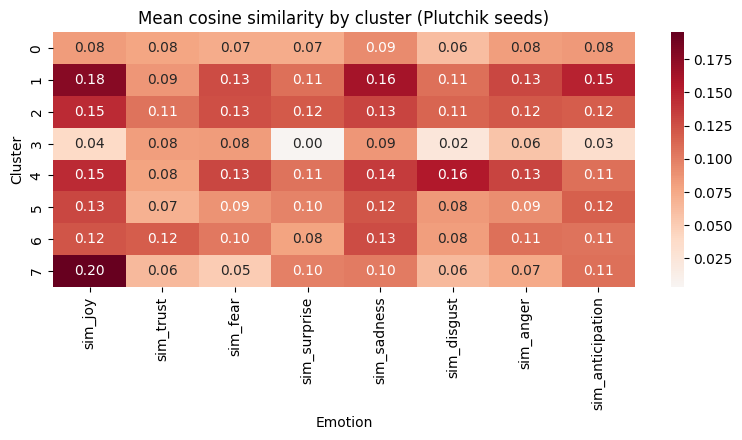

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

In [ ]:
# pt.3 Cluster-mean heatmap + platform/modality stratify

cluster_means = dfS.groupby("Cluster_SBERT")[S_df.columns].mean()
cluster_means.to_csv(os.path.join(VAL, "cluster_emotion_means.csv"))

plt.figure(figsize=(8,4.5))
sns.heatmap(cluster_means, annot=True, fmt=".2f", cmap="RdBu_r", center=0.0)
plt.title("Mean cosine similarity by cluster (Plutchik seeds)")
plt.xlabel("Emotion"); plt.ylabel("Cluster")
plt.tight_layout(); plt.savefig(os.path.join(VAL, "heatmap_cluster_emotions.png"), dpi=250)
plt.show()

# Platform-stratified emotion profiles (per cluster)
plat_profiles = dfS.groupby(["Cluster_SBERT","Social_Media_Type"])[S_df.columns].mean().reset_index()
plat_profiles.to_csv(os.path.join(VAL, "cluster_platform_emotion_means.csv"), index=False)

# Modality-stratified emotion profiles (per cluster)
mod_profiles = dfS.groupby(["Cluster_SBERT","Modality_Type"])[S_df.columns].mean().reset_index()
mod_profiles.to_csv(os.path.join(VAL, "cluster_modality_emotion_means.csv"), index=False)

# Small multiples for platform
for emo_col in S_df.columns:
    plt.figure(figsize=(7,4))
    tmp = plat_profiles.pivot(index="Cluster_SBERT", columns="Social_Media_Type", values=emo_col)
    tmp.plot(kind="bar")
    plt.title(f"{emo_col} by platform within cluster")
    plt.xlabel("Cluster"); plt.ylabel("Mean cosine")
    plt.legend(title="Platform", bbox_to_anchor=(1.05,1), loc="upper left")
    plt.tight_layout(); plt.savefig(os.path.join(VAL, f"{emo_col}_by_platform_bar.png"), dpi=220)
    plt.close()

# Small multiples for modality
for emo_col in S_df.columns:
    plt.figure(figsize=(7,4))
    tmp = mod_profiles.pivot(index="Cluster_SBERT", columns="Modality_Type", values=emo_col)
    tmp.plot(kind="bar")
    plt.title(f"{emo_col} by modality within cluster")
    plt.xlabel("Cluster"); plt.ylabel("Mean cosine")
    plt.legend(title="Modality", bbox_to_anchor=(1.05,1), loc="upper left")
    plt.tight_layout(); plt.savefig(os.path.join(VAL, f"{emo_col}_by_modality_bar.png"), dpi=220)
    plt.close()

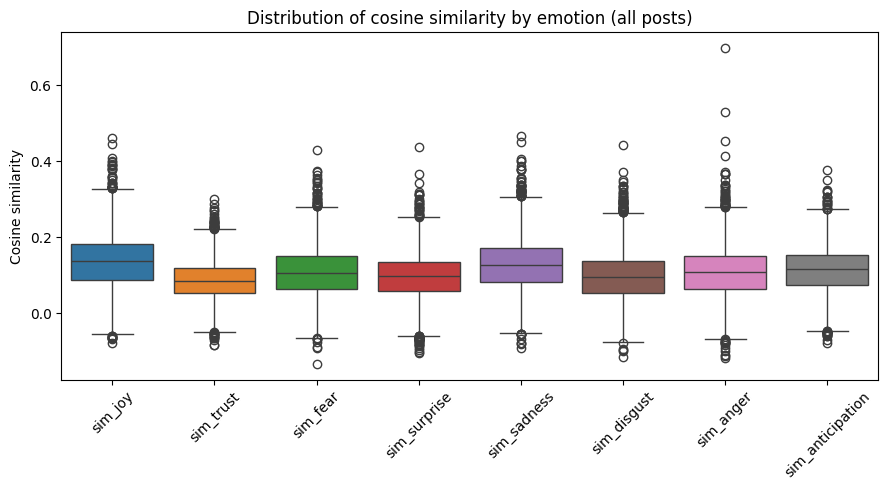

In [ ]:
# pt.4 - visual for variability: per-emotion distributions

plt.figure(figsize=(9,5))
sns.boxplot(data=dfS[[c for c in S_df.columns]])
plt.xticks(rotation=45)
plt.ylabel("Cosine similarity"); plt.title("Distribution of cosine similarity by emotion (all posts)")
plt.tight_layout(); plt.savefig(os.path.join(VAL, "emotion_similarity_boxplot_all_posts.png"), dpi=250)
plt.show()

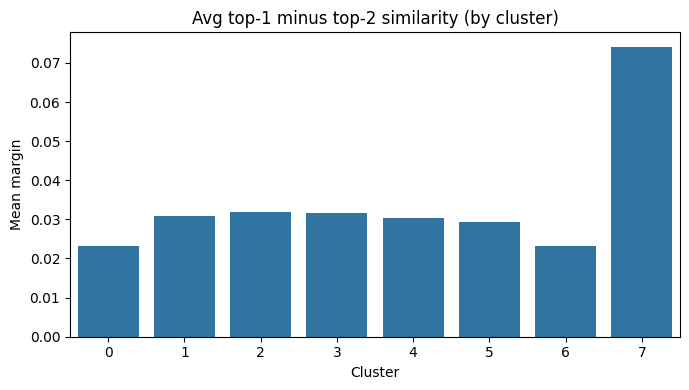

In [ ]:
# (pt.5) NARROWING data to = top-1 margin per post

S_vals = S_df.values
top1 = S_vals.max(axis=1)
top2 = np.partition(S_vals, -2, axis=1)[:,-2]
margin = top1 - top2
df_margin = pd.DataFrame({
    "Cluster": df["Cluster_SBERT"].values,
    "top1_margin": margin
})
df_margin.to_csv(os.path.join(VAL, "top1_margin_by_post.csv"), index=False)

marg = df_margin.groupby("Cluster")["top1_margin"].agg(["mean","median","count"])
marg.to_csv(os.path.join(VAL, "top1_margin_by_cluster.csv"))

plt.figure(figsize=(7,4))
sns.barplot(x=marg.index, y=marg["mean"])
plt.title("Avg top-1 minus top-2 similarity (by cluster)")
plt.xlabel("Cluster"); plt.ylabel("Mean margin")
plt.tight_layout(); plt.savefig(os.path.join(VAL, "top1_margin_by_cluster_bar.png"), dpi=220)
plt.show()

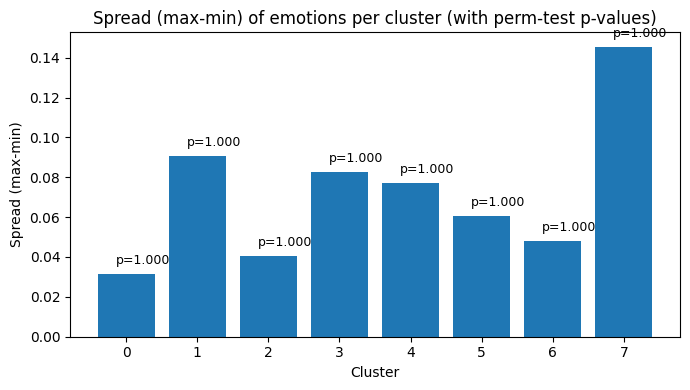

In [ ]:
# (pt.6) Sorting test (is pattern > chance?)

# Shuffle the mapping of centroids = emotion labels and recompute cluster means (advice from AI)
rng = np.random.default_rng(42)
n_perm = 200
true_spread = cluster_means.max(axis=1) - cluster_means.min(axis=1)  # per cluster

perm_spreads = []
emo_cols = S_df.columns
for _ in range(n_perm):
    perm_cols = rng.permutation(emo_cols)
    perm_means = dfS.groupby("Cluster_SBERT")[perm_cols].mean()
    spread = perm_means.max(axis=1) - perm_means.min(axis=1)
    perm_spreads.append(spread.values)

perm_spreads = np.vstack(perm_spreads)  # (n_perm, n_clusters)
pvals = (perm_spreads >= true_spread.values).mean(axis=0)  # one-sided
perm_df = pd.DataFrame({"Cluster": true_spread.index, "TrueSpread": true_spread.values, "p_value": pvals})
perm_df.to_csv(os.path.join(VAL, "permutation_spread_pvalues.csv"), index=False)

plt.figure(figsize=(7,4))
plt.bar(perm_df["Cluster"].astype(int), perm_df["TrueSpread"])
for i, p in enumerate(perm_df["p_value"].values):
    plt.text(i-0.15, perm_df["TrueSpread"].iloc[i]+0.005, f"p={p:.3f}", fontsize=9)
plt.title("Spread (max-min) of emotions per cluster (with perm-test p-values)")
plt.xlabel("Cluster"); plt.ylabel("Spread (max-min)")
plt.tight_layout(); plt.savefig(os.path.join(VAL, "spread_with_pvalues.png"), dpi=230)
plt.show()

Trying out new visual graph - spider chart

- Radar chart comparing emotions across social media platforms

In [ ]:
# Radar charts for 4.3:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

BASE = "/content/drive/MyDrive/msc_final_dataset"
RES  = os.path.join(BASE, "chapter4_results")
VAL  = os.path.join(RES, "validation")  # where saved the emotion similarities
os.makedirs(RES, exist_ok=True)

CANDIDATES = [
    os.path.join(VAL, "post_emotion_cosine_with_meta.csv"),
    os.path.join(RES, "post_emotion_cosine_with_meta.csv"),
]
DATA = next((p for p in CANDIDATES if os.path.exists(p)), None)
assert DATA is not None, "Could not find post_emotion_cosine_with_meta.csv (run 4.2.4 first)."

df = pd.read_csv(DATA)

# Emotion columns (keep this canonical order, aligns with Plutchik)
EMOS = ["joy","trust","fear","surprise","sadness","disgust","anger","anticipation"]
EMO_COLS = [f"sim_{e}" for e in EMOS]

present = [c for c in EMO_COLS if c in df.columns]
assert len(present) == len(EMO_COLS), f"Missing some emotion columns. Found: {present}"
assert "Social_Media_Type" in df.columns, "Need Social_Media_Type in the file."
assert "Modality_Type" in df.columns, "Need Modality_Type in the file."

# Aggregate means by platform and by modality
plat_means = df.groupby("Social_Media_Type")[EMO_COLS].mean().reindex(["Twitter","Reddit"], fill_value=np.nan)
mod_means  = df.groupby("Modality_Type")[EMO_COLS].mean().reindex(["Text-only","Text+Image","Image-only"], fill_value=np.nan)

# Replace any all-NaN rows (like) missing modality) with zeros for plotting
plat_means = plat_means.fillna(0.0)
mod_means  = mod_means.fillna(0.0)

plat_means, mod_means

(                    sim_joy  sim_trust  sim_fear  sim_surprise  sim_sadness  \
 Social_Media_Type                                                             
 Twitter            0.141809   0.084239  0.107074      0.100958     0.130399   
 Reddit             0.099524   0.098767  0.108944      0.065818     0.113400   
 
                    sim_disgust  sim_anger  sim_anticipation  
 Social_Media_Type                                            
 Twitter               0.099708   0.109807          0.118030  
 Reddit                0.072509   0.094323          0.083747  ,
                 sim_joy  sim_trust  sim_fear  sim_surprise  sim_sadness  \
 Modality_Type                                                             
 Text-only      0.133173   0.083707  0.104646      0.092609     0.126598   
 Text+Image     0.154918   0.118750  0.137831      0.124927     0.139345   
 Image-only     0.000000   0.000000  0.000000      0.000000     0.000000   
 
                sim_disgust  sim_anger  sim

In [ ]:
import numpy as np

def radar_plot(series_dict, categories, title="", outfile=None):
    """
    series_dict: dict like {"Twitter": np.array([...]), "Reddit": np.array([...])}
    categories: list of category labels (e.g., emotion names)
    """
    N = len(categories)
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # close the loop

    fig = plt.figure(figsize=(7.2, 6.6))
    ax = plt.subplot(111, polar=True)
    ax.set_theta_offset(np.pi / 2)    # start at the top
    ax.set_theta_direction(-1)

    # grid / ticks
    ax.set_rlabel_position(0)
    # Choose neat radial ticks based on overall value range
    all_vals = np.concatenate([v for v in series_dict.values()])
    rmax = float(np.nanmax(all_vals)) if all_vals.size else 0.3
    rticks = np.round(np.linspace(0, max(0.2, rmax), 4), 2)
    ax.set_yticks(rticks)
    ax.set_yticklabels([str(t) for t in rticks], fontsize=9)
    ax.set_ylim(0, max(0.2, rmax))

    # category labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=11)

    # plot each series
    for label, vals in series_dict.items():
        vals = np.asarray(vals, dtype=float)
        vals = np.nan_to_num(vals, nan=0.0)
        vals_c = np.concatenate([vals, vals[:1]])  # closed
        line = ax.plot(angles, vals_c, linewidth=2.0, label=label)[0]
        ax.fill(angles, vals_c, alpha=0.15, color=line.get_color())

    # plot graph
    ax.set_title(title, fontsize=13, pad=30)
    leg = ax.legend(loc="upper right", bbox_to_anchor=(1.20, 1.10), frameon=False)
    for txt in leg.get_texts():
        txt.set_fontsize(10)

    plt.tight_layout()
    if outfile:
        plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()

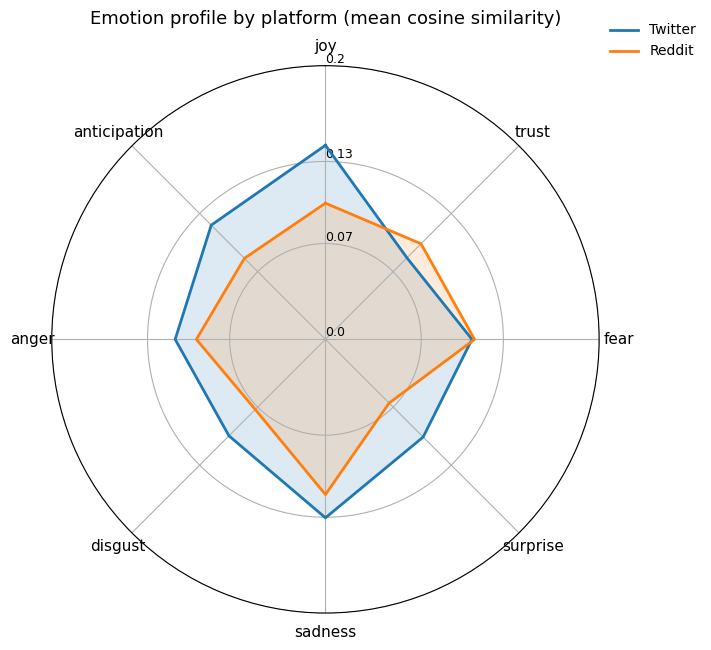

Saved: /content/drive/MyDrive/msc_final_dataset/chapter4_results/radar_platform_emotions.png


In [ ]:
# Build dict in the right order
tw_vec = plat_means.loc["Twitter", EMO_COLS].values
rd_vec = plat_means.loc["Reddit",  EMO_COLS].values

radar_plot(
    {"Twitter": tw_vec, "Reddit": rd_vec},
    categories=EMOS,
    title="Emotion profile by platform (mean cosine similarity)",
    outfile=os.path.join(RES, "radar_platform_emotions.png"),
)
print("Saved:", os.path.join(RES, "radar_platform_emotions.png"))

Radar chart comparing emotion profiles across modalities:
- Text-only
- Text + image
- Image-only

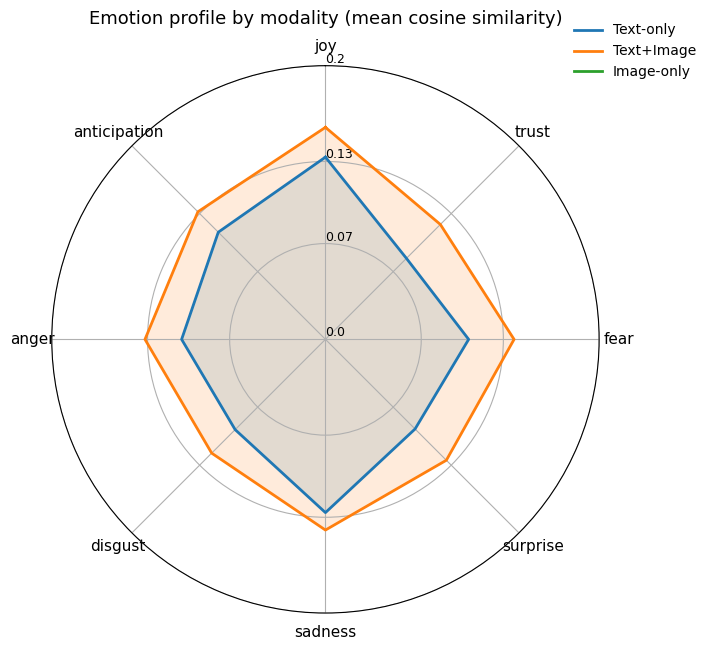

Saved: /content/drive/MyDrive/msc_final_dataset/chapter4_results/radar_modality_emotions.png


In [ ]:
series = {}
for mod in ["Text-only","Text+Image","Image-only"]:
    if mod in mod_means.index:
        series[mod] = mod_means.loc[mod, EMO_COLS].values

radar_plot(
    series,
    categories=EMOS,
    title="Emotion profile by modality (mean cosine similarity)",
    outfile=os.path.join(RES, "radar_modality_emotions.png"),
)
print("Saved:", os.path.join(RES, "radar_modality_emotions.png"))

In [ ]:
# Find image only rows (why it doesnt appear in graph??)
m_counts = df["Modality_Type"].value_counts(dropna=False)
print(m_counts)

# For each modality, how many non-NaN similarities do we have?
sim_cols = [c for c in df.columns if c.startswith("sim_")]  # or use dfS if that's where sims are
avail = df.groupby("Modality_Type")[sim_cols].apply(lambda x: x.notna().all(axis=1).sum())
print(avail)

Modality_Type
Text-only     5475
Text+Image     491
Name: count, dtype: int64
Modality_Type
Text+Image     491
Text-only     5475
dtype: int64


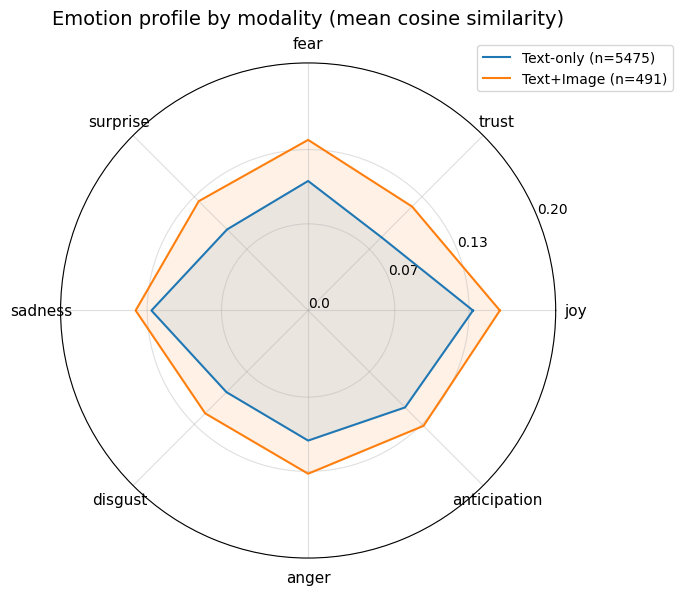

In [ ]:
# Radar: emotion profiles by modality (Text-only vs Text+Image vs Image-only)
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

BASE = "/content/drive/MyDrive/msc_final_dataset"
RES  = os.path.join(BASE, "chapter4_results")

emotions = ["sim_joy","sim_trust","sim_fear","sim_surprise",
            "sim_sadness","sim_disgust","sim_anger","sim_anticipation"]

# 1) ensure we have dfS with Modality_Type + sim_* columns
need_load = True
if 'dfS' in globals():
    if all(c in dfS.columns for c in ["Modality_Type"] + emotions):
        need_load = False

if need_load:
    candidates = [
        os.path.join(RES, "validation", "post_emotion_cosine_with_meta.csv"),
        os.path.join(RES, "robustness", "post_emotion_cosine_with_meta.csv"),
        os.path.join(RES, "post_emotion_cosine_with_meta.csv"),
    ]
    src = next((p for p in candidates if os.path.exists(p)), None)
    if src is None:
        raise FileNotFoundError("Could not find post_emotion_cosine_with_meta.csv; run the emotion-similarity step first.")
    dfS = pd.read_csv(src)

# 2) compute means (and Ns) safely
# rows that have all sim_* values present
mask_valid = dfS[emotions].notna().all(axis=1)
means = (dfS.loc[mask_valid]
         .groupby("Modality_Type")[emotions]
         .mean()
         .reindex(["Text-only","Text+Image","Image-only"]))  # set order if present

Ns = (dfS.loc[mask_valid]
      .groupby("Modality_Type").size()
      .reindex(["Text-only","Text+Image","Image-only"]))

# 3) build radar values
labels = ["joy","trust","fear","surprise","sadness","disgust","anger","anticipation"]
theta = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
theta = np.concatenate([theta, theta[:1]])  # close loop

def line_for(mod):
    if mod not in means.index or means.loc[mod].isna().all():
        return None
    vals = means.loc[mod, emotions].values
    return np.concatenate([vals, vals[:1]])

plt.figure(figsize=(7,7))
ax = plt.subplot(111, polar=True)

series = []

lo = line_for("Text-only")
if lo is not None:
    ax.plot(theta, lo, label=f"Text-only (n={int(Ns.get('Text-only',0))})")
    ax.fill(theta, lo, alpha=0.1)
    series.append("Text-only")

li = line_for("Text+Image")
if li is not None:
    ax.plot(theta, li, label=f"Text+Image (n={int(Ns.get('Text+Image',0))})")
    ax.fill(theta, li, alpha=0.1)
    series.append("Text+Image")

io = line_for("Image-only")
# Only draw if there are actually rows with all sim_* (often 0 for meme-only without OCR)
if io is not None and not np.allclose(io, 0):
    ax.plot(theta, io, label=f"Image-only (n={int(Ns.get('Image-only',0))})", linestyle="--")
    ax.fill(theta, io, alpha=0.05)
    series.append("Image-only")

ax.set_xticks(theta[:-1])
ax.set_xticklabels(labels, fontsize=11)
ax.set_yticks([0.0, 0.07, 0.13, 0.20])
ax.set_yticklabels(["0.0","0.07","0.13","0.20"])
ax.set_ylim(0, 0.20)
ax.grid(True, alpha=0.4)

ax.set_title("Emotion profile by modality (mean cosine similarity)", pad=28, fontsize=14)
if series:
    ax.legend(loc="upper right", bbox_to_anchor=(1.25, 1.05))
else:
    print("No valid modality series to plot (check that sim_* columns exist and are non-empty).")

plt.tight_layout()
plt.show()

+ MORE VISUALS -

TF-IDF word cloud per modality

*(accomplished with the help of Gemini)*

In [ ]:
print(df.columns.tolist())

['Cluster_SBERT', 'Social_Media_Type', 'Modality_Type', 'Subcommunity_Tag', 'sim_joy', 'sim_trust', 'sim_fear', 'sim_surprise', 'sim_sadness', 'sim_disgust', 'sim_anger', 'sim_anticipation']


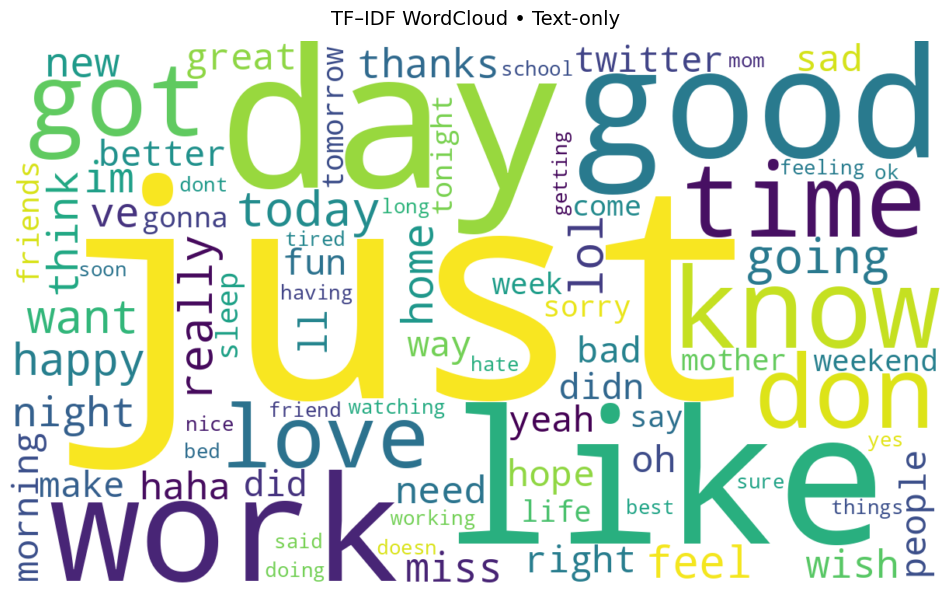

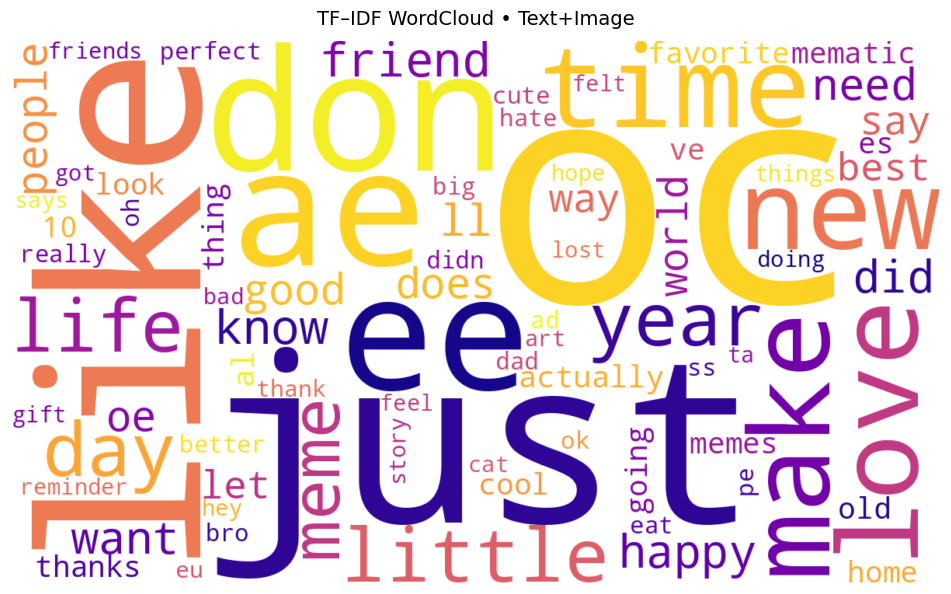

Saved summary -> /content/drive/MyDrive/msc_final_dataset/chapter4_results/wordclouds/wordclouds_summary.csv


,Modality,N_docs,TopTermsCSV,WordCloudPNG
0,Text-only,5475,/content/drive/MyDrive/msc_final_dataset/chapt...,/content/drive/MyDrive/msc_final_dataset/chapt...
1,Text+Image,491,/content/drive/MyDrive/msc_final_dataset/chapt...,/content/drive/MyDrive/msc_final_dataset/chapt...


In [ ]:
# === TF–IDF Word Clouds by Modality:
import os, re, numpy as np, pandas as pd
import matplotlib.pyplot as plt

# 0) Paths
BASE = "/content/drive/MyDrive/msc_final_dataset"
RES  = os.path.join(BASE, "chapter4_results")
os.makedirs(RES, exist_ok=True)

# Try files that contain text
CANDIDATES = [
    os.path.join(RES,  "final_with_clusters_k8.csv"),     # clustered + text (preferred)
    os.path.join(BASE, "final_reclassified.csv"),         # raw after cleaning
    os.path.join(BASE, "final_with_images_ocr.csv"),      # made before
]

DATA = next((p for p in CANDIDATES if os.path.exists(p)), None)
assert DATA is not None, f"None of the candidate data files exist:\n" + "\n".join(CANDIDATES)

df_text = pd.read_csv(DATA)

# 1) Ensure we have Modality + text
assert "Modality_Type" in df_text.columns, "Modality_Type not found in dataset."
# Build Text_Combined if needed
if "Text_Combined" not in df_text.columns:
    t = df_text.get("Text", "").astype(str).fillna("")
    o = df_text.get("OCR_Text", "").astype(str).fillna("")
    df_text["Text_Combined"] = (t + " " + o).str.strip()

# 2) Light text clean for WordCloud/TF-IDF
def clean_text(s: str) -> str:
    s = s.lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)     # URLs
    s = re.sub(r"@\w+", " ", s)                 # @mentions
    s = re.sub(r"#", " ", s)                    # keep hashtag token but drop '#'
    s = re.sub(r"[^a-z0-9\s]+", " ", s)         # keep alnum/space
    s = re.sub(r"\s+", " ", s).strip()
    return s

df_text["text_clean"] = df_text["Text_Combined"].astype(str).map(clean_text)

# 3) TF–IDF per modality + WordClouds
!pip -q install wordcloud
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer

WC_DIR = os.path.join(RES, "wordclouds")
os.makedirs(WC_DIR, exist_ok=True)

stop_extra = {
    "im","ive","dont","cant","didnt","doesnt","youre","hes","shes","theyre",
    "rt","amp","u","ur","ok","yall","lol","yeah","like","just","know","time",
    "love","good","day","today"  # soften ultra-common non-topical terms
}
stopwords = STOPWORDS.union(stop_extra)

modalities = ["Text-only", "Text+Image", "Image-only"]
# keep only modalities that actually exist in your data
mods_present = [m for m in modalities if (df_text["Modality_Type"] == m).any()]

# Vectorizer shared (unigram+bigram, ignore very rare and very common)
vectorizer = TfidfVectorizer(stop_words="english", ngram_range=(1,2), min_df=5, max_df=0.5)

summary_rows = []

for mod in mods_present:
    sub = df_text[df_text["Modality_Type"] == mod]
    corpus = sub["text_clean"].tolist()
    if len([c for c in corpus if c]) < 10:
        print(f"[skip] Not enough text in modality: {mod}")
        continue

    X = vectorizer.fit_transform(corpus)
    terms = np.array(vectorizer.get_feature_names_out())
    # Mean TF-IDF across docs in this modality
    mean_w = np.asarray(X.mean(axis=0)).ravel()
    order = np.argsort(mean_w)[::-1]
    top_terms = terms[order][:80]     # 80 terms for cloud
    top_weights = mean_w[order][:80]

    # Save a CSV of top terms for this modality
    top_k = 30
    df_top = pd.DataFrame({"term": terms[order][:top_k], "weight": mean_w[order][:top_k]})
    csv_out = os.path.join(WC_DIR, f"tfidf_top_terms_{mod.replace('+','_')}.csv")
    df_top.to_csv(csv_out, index=False)

    # Build word->weight dict for wordcloud
    freqs = {t:w for t, w in zip(top_terms, top_weights)}

    cmap_by_mod = {
    "Text-only":  "viridis",
    "Text+Image": "plasma",
    "Image-only": "cividis",
    }
    cmap = cmap_by_mod.get(mod, "viridis")

    wc = WordCloud(width=1200, height=700,
                   background_color="white",
                   stopwords=stopwords,
                   colormap = cmap,
                   collocations=False,
                   prefer_horizontal=0.9).generate_from_frequencies(freqs)

    plt.figure(figsize=(10,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"TF–IDF WordCloud • {mod}", fontsize=14, pad=12)
    png_out = os.path.join(WC_DIR, f"wordcloud_{mod.replace('+','_')}.png")
    plt.tight_layout()
    plt.savefig(png_out, dpi=250)
    plt.show()

    summary_rows.append({"Modality": mod, "N_docs": len(sub), "TopTermsCSV": csv_out, "WordCloudPNG": png_out})

summary = pd.DataFrame(summary_rows)
summary_path = os.path.join(WC_DIR, "wordclouds_summary.csv")
summary.to_csv(summary_path, index=False)
print("Saved summary ->", summary_path)
summary

In [ ]:
import os, pickle
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer

# === Paths ===
BASE = "/content/drive/MyDrive/msc_final_dataset"
RES  = os.path.join(BASE, "chapter4_results")
DATA = os.path.join(RES, "final_with_clusters_k8.csv")
OUT  = os.path.join(RES, "final_with_clusters_k8_withSims.csv")

df = pd.read_csv(DATA)

# === Step 1: SBERT model (same as before) ===
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

# === Step 2: Plutchik seeds ===
plutchik_seeds = {
    "joy": ["happy","joy","cheerful","delighted","content"],
    "trust": ["trust","secure","faith","confidence","reliable"],
    "fear": ["fear","afraid","scared","terrified","worried"],
    "surprise": ["surprised","astonished","shocked","amazed","startled"],
    "sadness": ["sad","unhappy","sorrow","gloom","grief"],
    "disgust": ["disgust","revolted","gross","nauseated","repelled"],
    "anger": ["angry","furious","irritated","annoyed","mad"],
    "anticipation": ["anticipation","hopeful","excited","expecting","looking forward"]
}

# === Step 3: Encode seeds -> centroids ===
centroids = {}
for emo, words in plutchik_seeds.items():
    vecs = model.encode(words, normalize_embeddings=True)
    centroids[emo] = np.mean(vecs, axis=0)

# Save centroids so we don’t redo later
pickle.dump(centroids, open(os.path.join(RES, "plutchik_centroids.pkl"), "wb"))

# === Step 4: Encode posts ===
text_series = df.get("Text_Combined", df.get("Text", "")).astype(str).fillna("").tolist()
emb = model.encode(text_series, batch_size=64, normalize_embeddings=True, show_progress_bar=True)

# === Step 5: Compute similarities ===
for emo, cvec in centroids.items():
    df[f"sim_{emo}"] = np.dot(emb, cvec)

# === Step 6: Get Top-1 AI emotion per post ===
sim_cols = [f"sim_{emo}" for emo in plutchik_seeds.keys()]
df["AI_Emotion"] = df[sim_cols].idxmax(axis=1).str.replace("sim_","")

# === Save final file ===
df.to_csv(OUT, index=False)
print("✅ Saved with sim_* and AI_Emotion ->", OUT)

Batches:   0%|          | 0/94 [00:00<?, ?it/s]

✅ Saved with sim_* and AI_Emotion -> /content/drive/MyDrive/msc_final_dataset/chapter4_results/final_with_clusters_k8_withSims.csv


Human Annotation Form A :

(https://forms.gle/R4vLLsyY9ognfw2Z6)

Initial Analysis

In [ ]:
resp_path = "/content/drive/MyDrive/msc_final_dataset/annotation_forms/human_annotation_form_responses_A.csv"
df = pd.read_csv(resp_path)
print(df.columns.tolist())

['Respondent_ID', 'Post_ID', 'Age_Range', 'Gender', 'Familiarity ', 'Frequency', 'Platform', 'Human_Emotion']


In [ ]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

# Re-load the cleaned file we just saved
BASE = "/content/drive/MyDrive/msc_final_dataset"
OUT  = os.path.join(BASE, "chapter4_results", "human_analysis")
df   = pd.read_csv(os.path.join(OUT, "human_responses_clean.csv"))

# Ensure Post_ID is a string and Human_Emotion is valid
df["Post_ID"] = df["Post_ID"].astype(str).str.strip()
df["Human_Emotion"] = df["Human_Emotion"].astype(str).str.strip()
df = df[df["Human_Emotion"].str.len() > 0]  # drop blanks

# Natural sort by the numeric tail if present (e.g., Q01, Q2, 3, etc.)
def numeric_key(pid):
    m = re.search(r'(\d+)$', str(pid))
    return (re.sub(r'\d+$','', str(pid)), int(m.group(1)) if m else 0)

unique_pids = sorted(df["Post_ID"].unique().tolist(), key=numeric_key)

# Helper to make a safe filename from Post_ID
def safe_name(s):
    return re.sub(r"[^A-Za-z0-9_-]+", "_", str(s))

# Per-post pies (now robust to string Post_IDs)
for pid in unique_pids:
    sub = df[df["Post_ID"] == pid]
    counts = sub["Human_Emotion"].value_counts()
    if counts.sum() == 0:
        continue  # nothing to plot

    plt.figure(figsize=(6,6))
    plt.pie(counts.values, labels=counts.index, autopct="%1.0f%%", startangle=135)
    plt.title(f"Human-Annotated Emotions • Post {pid}", pad=16)
    plt.tight_layout()

    out_path = os.path.join(OUT, f"post_{safe_name(pid)}_emotion_pie.png")
    plt.savefig(out_path, dpi=220)
    plt.close()

print(f"Saved {len(unique_pids)} per-post pies to:", OUT)

Saved 20 per-post pies to: /content/drive/MyDrive/msc_final_dataset/chapter4_results/human_analysis


File checks:

In [ ]:
import os, pandas as pd

posts_csv = "/content/drive/MyDrive/msc_final_dataset/annotation_forms/human_annotation_form_posts_A.csv"
resp_csv  = "/content/drive/MyDrive/msc_final_dataset/annotation_forms/human_annotation_form_responses_A.csv"

assert os.path.exists(posts_csv), f"Missing posts: {posts_csv}"
assert os.path.exists(resp_csv),  f"Missing responses: {resp_csv}"

posts = pd.read_csv(posts_csv)
resp  = pd.read_csv(resp_csv)

# 1) must have Post_ID
assert "Post_ID" in posts.columns, "Posts need Post_ID"

# 2) try to find a text-bearing column and normalise to Text_Combined
#    Add any custom column names you used into this list:
TEXT_CANDIDATES = [
    "Text_Combined", "Text", "OCR_Text",     # your earlier schema
    "Post_Text", "Post", "Content", "Prompt",
    "Question", "Item_Text", "Displayed_Text"
]

# pick first present column that looks like the actual post text
present = [c for c in TEXT_CANDIDATES if c in posts.columns]
if "Text_Combined" in posts.columns:
    posts["Text_Combined"] = posts["Text_Combined"].astype(str)
elif {"Text","OCR_Text"}.issubset(posts.columns):
    posts["Text_Combined"] = (
        posts["Text"].astype(str).fillna("") + " " +
        posts["OCR_Text"].astype(str).fillna("")
    ).str.strip()
elif present:
    # use the first available candidate as Text_Combined
    src = present[0]
    posts["Text_Combined"] = posts[src].astype(str)
else:
    raise AssertionError(
        "Could not find any text column to score.\n"
        f"Posts columns = {posts.columns.tolist()}\n"
        "Please add one of: Text_Combined / (Text+OCR_Text) / Post_Text / Prompt / Content."
    )

# quick sanity checks
print("Using text column for scoring -> 'Text_Combined'")
print(posts[["Post_ID","Text_Combined"]].head(3))

# overwrite the CSV (optional), or just keep `posts` in memory
posts.to_csv(posts_csv, index=False)

# responses must have Post_ID + Human_Emotion
assert {"Post_ID","Human_Emotion"}.issubset(resp.columns), "Responses need Post_ID and Human_Emotion"

# check overlap is healthy
missing_posts = set(resp["Post_ID"]) - set(posts["Post_ID"])
print("Responses referencing missing Post_IDs:", (missing_posts if missing_posts else "None ✅"))

AssertionError: Could not find any text column to score.
Posts columns = ['Post_ID', 'Text_For_Survey', 'Emoji', 'Image_URL', 'Social_Media_Type', 'Subcommunity_Tag', 'Modality_Type', 'Cluster_SBERT_k8']
Please add one of: Text_Combined / (Text+OCR_Text) / Post_Text / Prompt / Content.

✅ Using 'Text_For_Survey' -> Text_Combined
Accuracy: 0.331 | Macro-F1: 0.242 | κ: 0.211


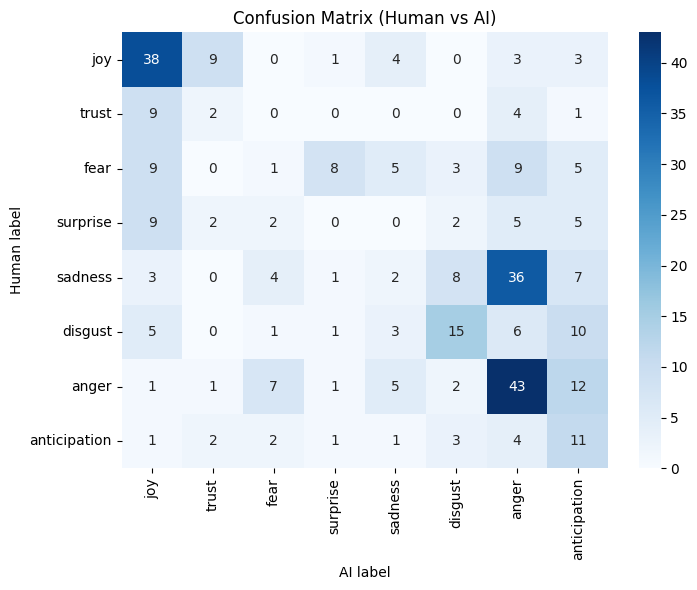

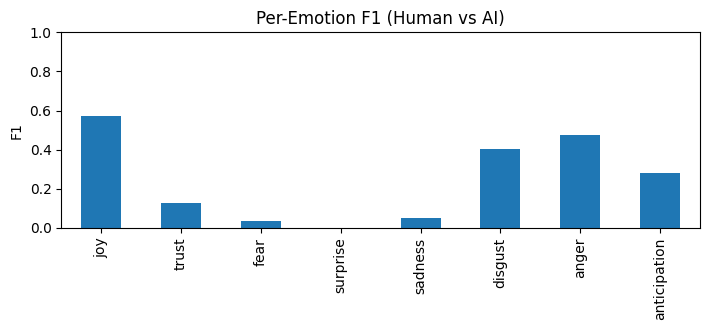

[Majority] Accuracy: 0.350 | Macro-F1: 0.259 | κ: 0.222


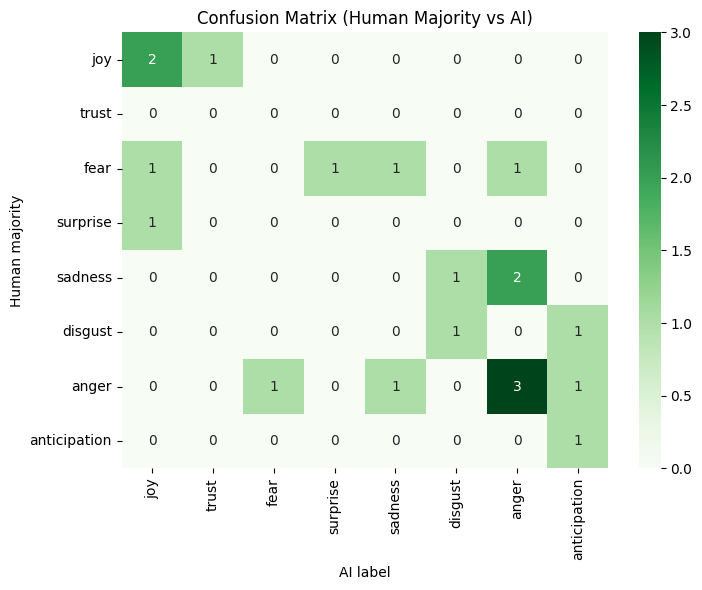


Saved outputs → /content/drive/MyDrive/msc_final_dataset/chapter4_results/human_vs_ai


In [ ]:
import os, json, numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, confusion_matrix, classification_report
from sentence_transformers import SentenceTransformer

BASE = "/content/drive/MyDrive/msc_final_dataset"
RES  = os.path.join(BASE, "chapter4_results")
OUT  = os.path.join(RES, "human_vs_ai")
os.makedirs(OUT, exist_ok=True)

posts_csv = os.path.join(BASE, "annotation_forms/human_annotation_form_posts_A.csv")
resp_csv  = os.path.join(BASE, "annotation_forms/human_annotation_form_responses_A.csv")
assert os.path.exists(posts_csv), f"Missing posts: {posts_csv}"
assert os.path.exists(resp_csv),  f"Missing responses: {resp_csv}"

posts = pd.read_csv(posts_csv)
resp  = pd.read_csv(resp_csv)


#  columns: ['Post_ID','Text_For_Survey','Emoji','Image_URL','Social_Media_Type','Subcommunity_Tag','Modality_Type','Cluster_SBERT_k8']
assert "Post_ID" in posts.columns, "Posts need Post_ID"

# Build Text_Combined from Text_For_Survey (+ optional emoji as text tokens)
if "Text_For_Survey" in posts.columns:
    # append emoji string if present (helps emotion signal a bit)
    em = posts.get("Emoji", "").fillna("").astype(str)
    base = posts["Text_For_Survey"].fillna("").astype(str)
    posts["Text_Combined"] = (base + " " + em).str.strip()
else:
    raise AssertionError("Expected 'Text_For_Survey' column in posts file.")

# Save patched posts (optional)
posts.to_csv(posts_csv, index=False)
print("✅ Using 'Text_For_Survey' -> Text_Combined")

# Responses must have Post_ID + Human_Emotion
assert {"Post_ID","Human_Emotion"}.issubset(resp.columns), "Responses need Post_ID and Human_Emotion"

# Normalise human labels
PLUTCHIK = ["joy","trust","fear","surprise","sadness","disgust","anger","anticipation"]
EMO_MAP = {
    # base
    "joy":"joy","trust":"trust","fear":"fear","surprise":"surprise","sadness":"sadness",
    "disgust":"disgust","anger":"anger","anticipation":"anticipation",
    # common variants
    "happy":"joy","happiness":"joy","funny":"joy","laughter":"joy","love":"joy",
    "hope":"anticipation","excited":"anticipation",
    "anxiety":"fear","fear / anxiety":"fear","worried":"fear",
    "shock":"surprise","shocked":"surprise","amazed":"surprise","confusion":"surprise",
    "depressed":"sadness","upset":"sadness","crying":"sadness",
    "gross":"disgust","vile":"disgust","not funny":"disgust",
    "hate":"anger","annoyed":"anger","mad":"anger",
    # blanks
    "":None,"n/a":None
}
def norm_emotion(s):
    if pd.isna(s): return None
    s = str(s).strip().lower()
    return EMO_MAP.get(s, s if s in PLUTCHIK else None)

resp["Human_Emotion_std"] = resp["Human_Emotion"].map(norm_emotion)
resp_clean = resp.dropna(subset=["Human_Emotion_std"]).copy()

# Build Plutchik centroids (+synonyms)
seed_dict = {
    "joy":         ["joy","happy","happiness","glad","delighted","cheerful","😂","😊","😍"],
    "trust":       ["trust","reassured","secure","confidence","reliable","dependable"],
    "fear":        ["fear","afraid","anxious","scared","terrified","panic","😨"],
    "surprise":    ["surprise","astonished","shocked","amazed","unexpected","😲"],
    "sadness":     ["sadness","sad","down","depressed","sorrow","heartbroken","😭"],
    "disgust":     ["disgust","gross","revolted","nauseated","repulsed","🤢"],
    "anger":       ["anger","angry","furious","irritated","outraged","😡"],
    "anticipation":["anticipation","eager","excited","hopeful","expectant","🤞"]
}
emotions = list(seed_dict.keys())

centroids_pkl = os.path.join(RES, "plutchik_centroids.pkl")
def build_centroids():
    model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
    emo_ptr = {}
    for emo, terms in seed_dict.items():
        emb = model.encode(terms, normalize_embeddings=True, batch_size=32, show_progress_bar=False)
        emo_ptr[emo] = emb.mean(axis=0, keepdims=True)
    return emo_ptr

import pickle
if os.path.exists(centroids_pkl):
    centroids = pickle.load(open(centroids_pkl,"rb"))
    # sanity
    if not all(k in centroids for k in emotions):
        centroids = build_centroids()
        pickle.dump(centroids, open(centroids_pkl,"wb"))
else:
    centroids = build_centroids()
    pickle.dump(centroids, open(centroids_pkl,"wb"))

# Score only posts used in Form A:
post_sub = posts[posts["Post_ID"].isin(resp_clean["Post_ID"])].drop_duplicates("Post_ID").reset_index(drop=True)

model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
X = model.encode(post_sub["Text_Combined"].astype(str).tolist(),
                 normalize_embeddings=True, batch_size=64, show_progress_bar=False)

S = {f"sim_{emo}": (X @ centroids[emo].T).ravel() for emo in emotions}
S_df = pd.DataFrame(S)
post_ai = pd.concat([post_sub[["Post_ID","Text_Combined"]].reset_index(drop=True), S_df], axis=1)
sim_cols = [c for c in post_ai.columns if c.startswith("sim_")]
post_ai["AI_Emotion"] = post_ai[sim_cols].idxmax(axis=1).str.replace("sim_","",regex=False)
post_ai.to_csv(os.path.join(OUT, "formA_posts_with_AI_scores.csv"), index=False)

# Merge & metrics
merged = resp_clean.merge(post_ai[["Post_ID","AI_Emotion"] + sim_cols], on="Post_ID", how="inner")

# keep valid labels
mask = merged["Human_Emotion_std"].isin(PLUTCHIK) & merged["AI_Emotion"].isin(PLUTCHIK)
eval_df = merged.loc[mask].copy()

y_true = eval_df["Human_Emotion_std"].values
y_pred = eval_df["AI_Emotion"].values

acc   = accuracy_score(y_true, y_pred)
macro = f1_score(y_true, y_pred, average="macro")
kappa = cohen_kappa_score(y_true, y_pred, labels=PLUTCHIK)

print(f"Accuracy: {acc:.3f} | Macro-F1: {macro:.3f} | κ: {kappa:.3f}")

# report + confusion
report = classification_report(y_true, y_pred, labels=PLUTCHIK, zero_division=0, output_dict=True)
pd.DataFrame(report).T.to_csv(os.path.join(OUT, "metrics_classification_report.csv"))

cm = confusion_matrix(y_true, y_pred, labels=PLUTCHIK)
plt.figure(figsize=(7.5,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=PLUTCHIK, yticklabels=PLUTCHIK)
plt.xlabel("AI label"); plt.ylabel("Human label")
plt.title("Confusion Matrix (Human vs AI)")
plt.tight_layout()
plt.savefig(os.path.join(OUT, "confusion_matrix_human_vs_ai.png"), dpi=250)
plt.show()

# per-emotion F1
per_f1 = pd.Series({emo: f1_score(y_true==(emo), y_pred==(emo)) for emo in PLUTCHIK})
plt.figure(figsize=(7.2,3.4))
per_f1.reindex(PLUTCHIK).plot(kind="bar")
plt.ylim(0,1); plt.ylabel("F1")
plt.title("Per-Emotion F1 (Human vs AI)")
plt.tight_layout()
plt.savefig(os.path.join(OUT, "per_emotion_f1_bar.png"), dpi=240)
plt.show()

# Majority vote per Post_ID
from collections import Counter
mv = (eval_df.groupby("Post_ID")["Human_Emotion_std"]
      .agg(lambda s: Counter(s).most_common(1)[0][0])
      .rename("Human_Majority"))

post_level = pd.concat([mv, post_ai.set_index("Post_ID")["AI_Emotion"]], axis=1).dropna().reset_index()
acc_mv   = accuracy_score(post_level["Human_Majority"], post_level["AI_Emotion"])
macro_mv = f1_score(post_level["Human_Majority"], post_level["AI_Emotion"], average="macro")
kappa_mv = cohen_kappa_score(post_level["Human_Majority"], post_level["AI_Emotion"], labels=PLUTCHIK)
print(f"[Majority] Accuracy: {acc_mv:.3f} | Macro-F1: {macro_mv:.3f} | κ: {kappa_mv:.3f}")

cm_mv = confusion_matrix(post_level["Human_Majority"], post_level["AI_Emotion"], labels=PLUTCHIK)
plt.figure(figsize=(7.5,6))
sns.heatmap(cm_mv, annot=True, fmt="d", cmap="Greens",
            xticklabels=PLUTCHIK, yticklabels=PLUTCHIK)
plt.xlabel("AI label"); plt.ylabel("Human majority")
plt.title("Confusion Matrix (Human Majority vs AI)")
plt.tight_layout()
plt.savefig(os.path.join(OUT, "confusion_matrix_majority_vs_ai.png"), dpi=250)
plt.show()

post_level.to_csv(os.path.join(OUT, "post_level_majority_vs_ai.csv"), index=False)

# Slices (if present)
for col in ["Social_Media_Type", "Modality_Type"]:
    if col in posts.columns:
        tmp = eval_df.merge(posts[["Post_ID", col]], on="Post_ID", how="left")
        rows = []
        for g, gdf in tmp.groupby(col):
            yt, yp = gdf["Human_Emotion_std"], gdf["AI_Emotion"]
            rows.append({
                col: g, "N": len(gdf),
                "accuracy": accuracy_score(yt, yp),
                "macro_f1": f1_score(yt, yp, average="macro"),
                "kappa": cohen_kappa_score(yt, yp, labels=PLUTCHIK)
            })
        pd.DataFrame(rows).to_csv(os.path.join(OUT, f"metrics_by_{col}.csv"), index=False)

print(f"\nSaved outputs → {OUT}")